# Size Sorts and p-Hacking
## 2024/12/04 何晟圣 邱锦棚
## 1. Package Preparation and Encoding Adjustment

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import statsmodels.api as sm
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import percent_format, date_format
import matplotlib
import matplotlib.pyplot as plt
import itertools
from joblib import Parallel, delayed, cpu_count
import warnings

warnings.filterwarnings("ignore") ## Avoid outputting unnecessary warnings
matplotlib.rcParams['font.sans-serif']=['SimHei'] ## normalize the font
matplotlib.rcParams['axes.unicode_minus']=False ## normalize the minus sign


## 2. Data Preparation


数据来源：CSMAR 数据库 

样本范围：深证A股+上证A股+科创板+创业板的上市公司

时间范围：1992年1月-2024年11月，月度数据

底层数据：上市公司基本情况+个股交易数据（月度）+无风险利率表（月度）

生成数据：crsp_monthly.xlsx + factor_ff3_monthly.xlsx


In [2]:
crsp_monthly=pd.read_excel('crsp_monthly.xlsx')
factors_ff3_monthly=pd.read_excel('factors_ff3_monthly.xlsx')

In [3]:
crsp_monthly.head()

,permno,month,altprc,mktcap1,mktcap2,ret1,ret2,exchange,exchcd,Nrrmtdt,...,Nindnme,Nnindcd,Nnindnme,IndcdZX,IndnmeZX,Statco,ret_excess1,ret_excess2,mktcap1_lag,mktcap2_lag
0,1,1992-02-01,31.55,1419400.46,2831664.34,0.012841,0.012841,深证A股,4,0.6092,...,银行业,J66,货币金融服务,J66,货币金融服务,A,0.6749,0.6749,1401404.89,2795763.68
1,1,1992-03-01,26.05,1758845.18,3508847.08,0.246049,0.244849,深证A股,4,0.6092,...,银行业,J66,货币金融服务,J66,货币金融服务,A,23.9957,23.8757,1419400.46,2831664.34
2,1,1992-04-01,38.50,2599444.89,5185820.06,0.477927,0.477927,深证A股,4,0.6092,...,银行业,J66,货币金融服务,J66,货币金融服务,A,47.1835,47.1835,1758845.18,3508847.08
3,1,1992-05-01,45.20,3051815.81,6088287.45,0.174026,0.174026,深证A股,4,0.6092,...,银行业,J66,货币金融服务,J66,货币金融服务,A,16.7934,16.7934,2599444.89,5185820.06
4,1,1992-06-01,42.00,2835758.06,5657258.25,-0.070796,-0.070796,深证A股,4,0.6092,...,银行业,J66,货币金融服务,J66,货币金融服务,A,-7.6888,-7.6888,3051815.81,6088287.45


In [4]:
factors_ff3_monthly.head()

,MarkettypeID,month,mkt_excess1,mkt_excess2,smb1,smb2,hml1,hml2
0,P9714,1992-01-01,0.016318,0.056959,0.051172,0.048346,0.126718,0.131068
1,P9714,1992-02-01,0.041201,0.051088,0.621067,0.602932,0.460999,0.464667
2,P9714,1992-03-01,0.111234,0.087455,0.049054,0.044437,0.103842,0.108682
3,P9714,1992-04-01,0.314558,0.258967,-0.158519,-0.134314,0.065103,0.037506
4,P9714,1992-05-01,0.638205,0.864257,0.183456,0.210423,0.390898,0.386044


## 3. Size Distribution

本节内容：
不同市值规模的公司占总市值的比例

不同交易所的市值占总市值的比例

计算各个交易所的min/max等统计指标

### 3.1  
基于月度数据，将公司划分为该月最大的1%/5%/10%/25%公司，并计算这4类公司占总市值的比例。

#### 3.1.1 流通市值

In [5]:
circulation_market_cap_concentration = (crsp_monthly.get(["month","mktcap1"])
                                        .groupby("month",group_keys=False)
                                        .apply(lambda x: x.assign(mktcap_group = lambda x: np.digitize(x["mktcap1"], np.percentile(x["mktcap1"], [75, 90, 95, 99])))) ## please refer to appendix 1 and 2
                                        .groupby("month",group_keys=False)
                                        .apply(lambda x: x.assign(Largest_1percent_of_stocks = ((x["mktcap1"][x["mktcap_group"]>=4]).sum()/x["mktcap1"].sum()), 
                                                       Largest_5percent_of_stocks = ((x["mktcap1"][x["mktcap_group"]>=3]).sum()/x["mktcap1"].sum()),
                                                       Largest_10percent_of_stocks = ((x["mktcap1"][x["mktcap_group"]>=2]).sum()/x["mktcap1"].sum()),
                                                       Largest_25percent_of_stocks = ((x["mktcap1"][x["mktcap_group"]>=1]).sum()/x["mktcap1"].sum()))
                                                       .tail(1) ## for the all the companies in a same month, they have the same value,thus we only need the last value
                                                       )
                                        .melt(id_vars="month",
                                              value_vars=["Largest_1percent_of_stocks", "Largest_5percent_of_stocks",
                                                          "Largest_10percent_of_stocks","Largest_25percent_of_stocks"],
                                                var_name="type",
                                                value_name="value") ## convert the dataframe to long format
                                        )                            

In [6]:
circulation_market_cap_concentration

,month,type,value
0,1992-02-01,Largest_1percent_of_stocks,0.336215
1,1992-03-01,Largest_1percent_of_stocks,0.342785
2,1992-04-01,Largest_1percent_of_stocks,0.278788
3,1992-05-01,Largest_1percent_of_stocks,0.175755
4,1992-06-01,Largest_1percent_of_stocks,0.164906
...,...,...,...
1571,2024-07-01,Largest_25percent_of_stocks,0.824633
1572,2024-08-01,Largest_25percent_of_stocks,0.824881
1573,2024-09-01,Largest_25percent_of_stocks,0.819447
1574,2024-10-01,Largest_25percent_of_stocks,0.805834


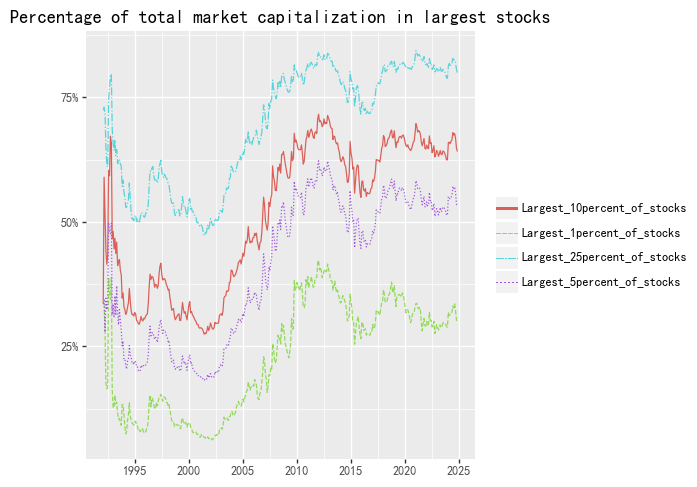

In [7]:
plot_circulation_market_cap_concentration = (ggplot(circulation_market_cap_concentration, 
                                                    aes(x="month", y="value", color="type", linetype="type")) +
                                                    geom_line() + 
                                                    scale_y_continuous(breaks=[0, 0.25, 0.5, 0.75, 1],labels=["0%", "25%", "50%", "75%", "100%"])+
                                                    scale_x_datetime(breaks=date_breaks("5 year"), labels=date_format("%Y")) + 
                                                    labs(x="", y="", color="", linetype="", 
                                                         title="Percentage of total market capitalization in largest stocks") +
                                                       theme(legend_title=element_blank())
                                                  ) ## plot the circulation_market_cap_concentration
plot_circulation_market_cap_concentration.draw()

结论：
1. 最大的1%公司占流通总市值的比重震荡上升，2013年达峰，目前占比不超过35%。
2. 最大的25%公司占据了75%以上的流通市值。

#### 3.1.2 总市值

In [8]:
total_market_cap_concentration = (crsp_monthly.get(["month","mktcap2"])
                                  .groupby("month",group_keys=False)
                                  .apply(lambda x: x.assign(mktcap_group = lambda x: np.digitize(x["mktcap2"], np.percentile(x["mktcap2"], [75, 90, 95, 99]))))
                                  .groupby("month",group_keys=False)
                                  .apply(lambda x: x.assign(Largest_1percent_of_stocks = ((x["mktcap2"][x["mktcap_group"]>=4]).sum()/x["mktcap2"].sum()),
                                                            Largest_5percent_of_stocks = ((x["mktcap2"][x["mktcap_group"]>=3]).sum()/x["mktcap2"].sum()),
                                                            Largest_10percent_of_stocks = ((x["mktcap2"][x["mktcap_group"]>=2]).sum()/x["mktcap2"].sum()),
                                                            Largest_25percent_of_stocks = ((x["mktcap2"][x["mktcap_group"]>=1]).sum()/x["mktcap2"].sum()))
                                                            .tail(1))
                                    .melt(id_vars="month",
                                          value_vars=["Largest_1percent_of_stocks", "Largest_5percent_of_stocks",
                                                      "Largest_10percent_of_stocks","Largest_25percent_of_stocks"],
                                            var_name="type",
                                            value_name="value")
                                        )                          

In [9]:
total_market_cap_concentration

,month,type,value
0,1992-02-01,Largest_1percent_of_stocks,0.300120
1,1992-03-01,Largest_1percent_of_stocks,0.293540
2,1992-04-01,Largest_1percent_of_stocks,0.207038
3,1992-05-01,Largest_1percent_of_stocks,0.131085
4,1992-06-01,Largest_1percent_of_stocks,0.127472
...,...,...,...
1571,2024-07-01,Largest_25percent_of_stocks,0.801370
1572,2024-08-01,Largest_25percent_of_stocks,0.802612
1573,2024-09-01,Largest_25percent_of_stocks,0.797964
1574,2024-10-01,Largest_25percent_of_stocks,0.784628


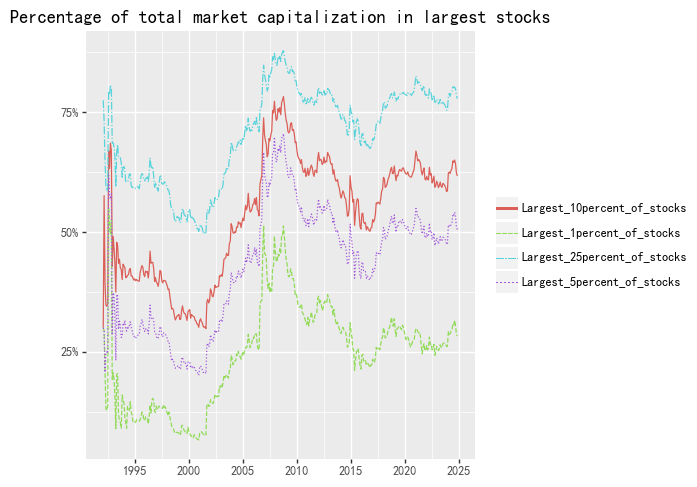

In [10]:
plot_total_market_cap_concentration = (ggplot(total_market_cap_concentration, 
                                        aes(x="month", y="value", color="type", linetype="type")) +
                                 geom_line() +
                                 scale_y_continuous(breaks=[0, 0.25, 0.5, 0.75, 1],labels=["0%", "25%", "50%", "75%", "100%"])+
                                 scale_x_datetime(breaks=date_breaks("5 year"), labels=date_format("%Y")) +
                                 labs(x="", y="", color="", linetype="", 
                                      title="Percentage of total market capitalization in largest stocks") +
                                 theme(legend_title=element_blank()))
plot_total_market_cap_concentration.draw()

结论：
1. 自2008年金融危机以来，最大的1%公司占总市值的比例持续震荡下降，目前约为30%。
3. 与前述流通市值情况一致，最大的25%公司占据了75%以上的总市值。

流通市值VS总市值
1. 二者走势大体相同，但在2007-2008期间，总市值相较流通市值大幅攀升。
2. 一个可能的原因：金融危机期间，A股市场大幅下跌，年跌幅达60%。流通市值的跌幅较大，大型上市公司由于其较高的非流通股比例，使其总市值在短期内相对稳定，从而导致总市值和流通市值之间的比例发生变化。
3. 总结：非流通股的相对稳定性使得总市值的波动较小，而流通市值则受市场整体下行压力的影响，表现较为疲软。

### 3.2  
基于月度数据，计算上证A股/深证A股/创业板/科创板的市值占比

#### 3.2.1 流通市值

In [ ]:
circulation_market_cap_share = (crsp_monthly
                                .groupby(["month","exchange"],group_keys=False)
                                .aggregate(mktcap=("mktcap1", lambda x: sum(x))) ##sum of mktcap
                                .reset_index() ##ungroup and reset month and exchange as columns
                                .groupby("month",group_keys=False)
                                .apply(lambda x: x.assign(share = x["mktcap"]/(x["mktcap"]).sum())) ##percentage of mktcap
                                )

In [12]:
circulation_market_cap_share.sort_values("month")

,month,exchange,mktcap,share
0,1992-02-01,上证A股,1.107462e+06,0.262326
1,1992-02-01,深证A股,3.114243e+06,0.737674
2,1992-03-01,上证A股,1.158751e+06,0.225831
3,1992-03-01,深证A股,3.972297e+06,0.774169
4,1992-04-01,上证A股,1.324980e+06,0.142103
...,...,...,...,...
1026,2024-10-01,创业板,9.755228e+09,0.128175
1030,2024-11-01,创业板,9.997577e+09,0.129416
1031,2024-11-01,深证A股,1.876207e+10,0.242870
1029,2024-11-01,上证A股,4.358199e+10,0.564158


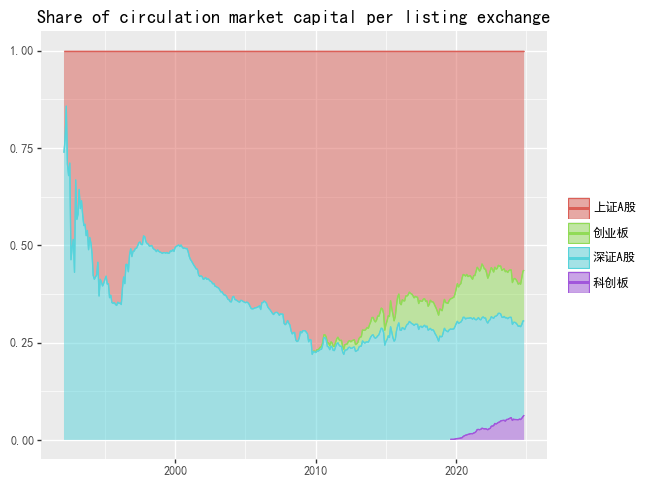

In [13]:
circulation_plot_market_cap_share=(ggplot(circulation_market_cap_share,
                                          aes(x="month",y="share",color="exchange",fill="exchange"))+
                                          geom_area(position="stack", stat="identity", alpha=0.5)+
                                          geom_line(position="stack") +
                                          scale_x_date(name="", date_labels="%Y") +
                                          labs(x="", y="", fill="", color="",
                                               title="Share of circulation market capital per listing exchange") +
                                               theme(legend_title=element_blank())
                                    )

circulation_plot_market_cap_share.draw()

结论：
1. 自1990年创立以来，总体而言，上证A股是境内市值最大的证券交易场所。
2. 相较千禧年前后的市值占比高位，目前深证A股的市值占比减少约1/3。
3. 创业板/科创板的市值占比逐年走高，科创导向的政策支持力度有望持续。

### 3.2.2 总市值

In [14]:
total_market_cap_share = (crsp_monthly
                          .groupby(["month","exchange"],group_keys=False)
                          .aggregate(mktcap=("mktcap2", lambda x: sum(x)))
                          .reset_index()
                          .groupby("month",group_keys=False)
                          .apply(lambda x: x.assign(share = x["mktcap"]/(x["mktcap"]).sum()))
                          )

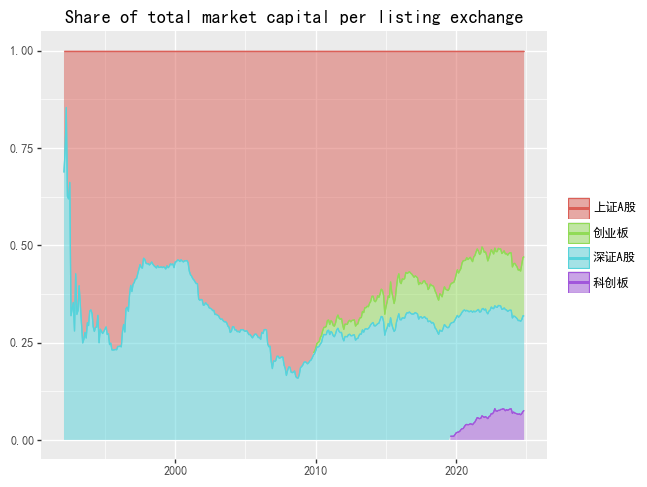

In [15]:
total_plot_market_cap_share=(ggplot(total_market_cap_share,
                                    aes(x="month",y="share",color="exchange",fill="exchange"))+
                                    geom_area(position="stack", stat="identity", alpha=0.5)+
                                    geom_line(position="stack") +
                                    scale_x_date(name="", date_labels="%Y") +
                                    labs(x="", y="", fill="", color="",
                                         title="Share of total market capital per listing exchange") +
                                    theme(legend_title=element_blank())
                              )

total_plot_market_cap_share.draw()

结论：
1. 自1990年创立以来，总体而言，上证A股是境内市值最大的证券交易场所。
2. 相较千禧年前后的市值占比高位，目前深证A股的市值占比有所减少。
3. 创业板/科创板的市值占比逐年走高，科创导向的政策支持力度有望持续。

流通市值VS总市值：
基本一致

## 3.3 
创建一个包含更加丰富指标的统计函数，将其应用于每个上市交易所最近一个月的CRSP数据，探索公司规模在上市交易所的分布

In [16]:
## create a function to summarize the data containing mean, std, min, q05, q50, q95, max, n
def create_summary(data, column_name):
    summary = (data[column_name]
               .agg(mean='mean',
                    std='std',
                    min='min',
                    q05=(lambda x: x.quantile(0.05)),
                    q50=(lambda x: x.quantile(0.50)),
                    q95=(lambda x: x.quantile(0.95)),
                    max='max',
                    n='count')
               )

    return summary

## get the max_month
max_month = crsp_monthly["month"].max()
print(max_month)

2024-11-01 00:00:00


### 3.3.1 流通市值

In [17]:
## calculate the summary statistics for the four market capitalization of the last month
circulation_summary1 = (crsp_monthly
                        .query("month == @max_month") ## @ means the variable not in the dataframe and import it from the outside
                        .groupby("exchange")
                        .apply(lambda x: create_summary(x, 'mktcap1')) 
                        )

## calculate the summary statistics for the overall market capitalization of the last month
circulation_summary2 = (create_summary((crsp_monthly
                                        .query("month == @max_month")
                                        .assign(exchange=lambda x: "Overall")
                                        .groupby("exchange",group_keys=False)),"mktcap1")
                        ) 

## combine the two summary statistics
pd.concat([circulation_summary1, circulation_summary2])

,mean,std,min,q05,q50,q95,max,n
exchange,,,,,,,,
上证A股,2.583402e+07,9.910854e+07,479795.26,1585771.842,6634687.04,9.758352e+07,1.916631e+09,1687.0
创业板,7.356568e+06,3.232278e+07,472172.25,924741.427,3097745.03,2.039011e+07,1.019504e+09,1359.0
深证A股,1.270283e+07,3.082656e+07,484774.20,1361779.234,5284415.08,4.183925e+07,5.696916e+08,1477.0
科创板,8.523963e+06,1.791595e+07,532939.55,1130488.960,4020426.89,2.765480e+07,2.341932e+08,576.0
Overall,1.515031e+07,6.244015e+07,472172.25,1157731.629,4675353.04,4.675867e+07,1.916631e+09,5099.0


结论：
1. 公司规模：上证A股的流通市值均值为25,834,020，远高于其他板块，公司规模普遍较大。创业板和科创板的均值分别为7,356,568和8,523,963，显著低于上证A股和深证A股，公司规模较小，体现高新技术的政策导向。
2. 市值分散：上证A股，深证A股和创业板的标准差分别为99,108,540、30,826,560和32,322,780，个股市值差异较大，存在较大的分散性。科创板的标准差较小，17,915,950，公司市值相对集中。

### 3.3.2 总市值

In [18]:
## calculate the summary statistics for the four market capitalization of the last month
total_summary1 = (crsp_monthly
                  .query("month == @max_month") ## @ means the variable not in the dataframe and import it from the outside
                  .groupby("exchange")
                  .apply(lambda x: create_summary(x, 'mktcap2')) 
                  )

## calculate the summary statistics for the overall market capitalization of the last month
total_summary2 = (create_summary((crsp_monthly
                                  .query("month == @max_month")
                                  .assign(exchange=lambda x: "Overall")
                                  .groupby("exchange",group_keys=False)),"mktcap2")
                    ) 

## combine the two summary statistics
pd.concat([total_summary1, total_summary2])

,mean,std,min,q05,q50,q95,max,n
exchange,,,,,,,,
上证A股,2.681012e+07,1.000690e+08,531300.00,2.006777e+06,7016192.61,9.850019e+07,1.916631e+09,1687.0
创业板,9.546603e+06,3.694737e+07,825659.50,1.874936e+06,4406917.89,2.435722e+07,1.150362e+09,1359.0
深证A股,1.407682e+07,3.303433e+07,754149.12,1.955743e+06,6003087.51,4.513931e+07,5.697036e+08,1477.0
科创板,1.126422e+07,2.227780e+07,868774.60,1.610139e+06,5148200.84,3.414180e+07,2.924250e+08,576.0
Overall,1.676450e+07,6.403204e+07,531300.00,1.920391e+06,5558520.86,5.096395e+07,1.916631e+09,5099.0


结论：
1. 市场资本化均值：上证A股的流通市值均值为26,810,120，仍然是所有板块中最高的，公司规模普遍较大，尤其是一些蓝筹股的市场表现显著。创业板和科创板的均值分别为9,546,603和11,264,220，公司普遍较小，对新兴企业的偏好明显。
2. 标准差：上证A股的标准差为100,069,000，依然是最高的，公司市值差异较大。科创板的标准差较小，为22,277,800，公司市值相对集中。

# 4. Univariate Size Portfolios with Flexible Breakpoints

目标：将给定的股票数据按其市值（mktcap_lag 列）分配到指定数量的投资组合（n_portfolios）中

具体步骤：
1. 根据市值数据（mktcap_lag 列）和指定的交易所（exchanges），筛选出数据。
2. 按市值将股票划分为指定数量的投资组合（n_portfolios），并返回投资组合的分组编号。

In [19]:
def assign_portfolio(data,exchanges,n_portfolios,mktcap_lag):

    if exchanges == ["创业板"]:
        data = data.query("exchange == '创业板'") ## select the data of the selected exchanges
    if exchanges == ["科创板"]:
        data = data.query("exchange == '科创板'")

    breakpoints = np.quantile(data.query("exchange in @exchanges")[mktcap_lag].dropna(),
                              np.linspace(0, 1, n_portfolios + 1)) ## generate the breakpoints and select the exchanges

    
    assigned_portfolios = np.digitize(data[mktcap_lag].dropna(), breakpoints) ## assign the portfolio based on the breakpoints

    assigned_portfolios[assigned_portfolios == (n_portfolios+1)] = n_portfolios ## assign the last portfolio to the last group and refer to appendix 3
    assigned_portfolios[assigned_portfolios == 0] = 1 ## assign the first portfolio to the first group and refer to appendix 3

    return assigned_portfolios

# 5. Weighting Schemes for Portfolios

## 5.1 Function and Date Preparation

根据不同的交易所和市值数据，计算不同投资组合的回报，并计算一个“市值溢价”（size premium）——通过做多小市值公司和做空大市值公司而得到的回报。

In [20]:
def compute_portfolio_returns(n_portfolios = 10,exchanges = ["上证A股", "深证A股", "创业板", "科创板"],
                              value_weighted = True,data = crsp_monthly,ret_excess = "ret_excess1",mktcap_lag = "mktcap1_lag"):
    if exchanges == ["创业板"]:
        data = data.query("exchange == '创业板'") ## select the data of the selected exchanges
    if exchanges == ["科创板"]:
        data = data.query("exchange == '科创板'")

    if data.empty:
        return -1

    returns_df = (data.groupby("month",group_keys=False)
               .apply(lambda x: x.assign(portfolio = assign_portfolio(x,exchanges=exchanges, n_portfolios=n_portfolios, mktcap_lag=mktcap_lag))) ## assign the portfolio
               .groupby(["month","portfolio"],group_keys=False)
               .apply(lambda x: np.where(value_weighted,
                                         np.average(x[ret_excess],weights=x[mktcap_lag]),
                                         np.mean(x[ret_excess])))  ## if value_weighted, calculate the weighted average, otherwise calculate the mean
               .reset_index(name="ret")
               .groupby("month",group_keys=False)

               .apply(lambda x: x.assign(min_size_ret = np.nanmean(x["ret"][x["portfolio"]==x["portfolio"].min()]),
                                         max_size_ret = np.nanmean(x["ret"][x["portfolio"]==x["portfolio"].max()])
                                        )
                     .tail(1)) ## for the all the companies in a same month, they have the same value,thus we only need the last value
               
               .assign(size_premium = lambda x: x["min_size_ret"]-x["max_size_ret"]) ## long small cap and short large cap
               )
    returns = returns_df["size_premium"].mean()

    return returns

In [21]:
circulation_crsp_monthly=crsp_monthly.get(["month","exchange","Indnme","Nindnme","mktcap1","mktcap1_lag","ret_excess1"])
total_crsp_monthly=crsp_monthly.get(["month","exchange","Indnme","Nindnme","mktcap2","mktcap2_lag","ret_excess1"])
print("Circulation Market Capital Dataframe:")
circulation_crsp_monthly.head()

Circulation Market Capital Dataframe:


,month,exchange,Indnme,Nindnme,mktcap1,mktcap1_lag,ret_excess1
0,1992-02-01,深证A股,金融,银行业,1419400.46,1401404.89,0.6749
1,1992-03-01,深证A股,金融,银行业,1758845.18,1419400.46,23.9957
2,1992-04-01,深证A股,金融,银行业,2599444.89,1758845.18,47.1835
3,1992-05-01,深证A股,金融,银行业,3051815.81,2599444.89,16.7934
4,1992-06-01,深证A股,金融,银行业,2835758.06,3051815.81,-7.6888


In [22]:
print("Total Market Capital Dataframe:")
total_crsp_monthly.head()

Total Market Capital Dataframe:


,month,exchange,Indnme,Nindnme,mktcap2,mktcap2_lag,ret_excess1
0,1992-02-01,深证A股,金融,银行业,2831664.34,2795763.68,0.6749
1,1992-03-01,深证A股,金融,银行业,3508847.08,2831664.34,23.9957
2,1992-04-01,深证A股,金融,银行业,5185820.06,3508847.08,47.1835
3,1992-05-01,深证A股,金融,银行业,6088287.45,5185820.06,16.7934
4,1992-06-01,深证A股,金融,银行业,5657258.25,6088287.45,-7.6888


## 5.2 流通市值

计算市场总体（上证A股+深证A股+创业板+科创板）的市场溢价情况

In [23]:
circulation_ret_all = compute_portfolio_returns(n_portfolios=2,
                                    exchanges=["上证A股", "深证A股", "创业板", "科创板"],
                                    value_weighted=True,
                                    data=circulation_crsp_monthly,
                                    ret_excess = "ret_excess1",
                                    mktcap_lag="mktcap1_lag")

In [24]:
print(circulation_ret_all)

1.7045553331699457


分别计算单个市场（上证A股/深证A股/创业板/科创板）的市场溢价情况

In [25]:
circulation_ret_SH = compute_portfolio_returns(n_portfolios=2,
                                               exchanges=["上证A股"],
                                               value_weighted=True,
                                               data=circulation_crsp_monthly,
                                               ret_excess = "ret_excess1",
                                               mktcap_lag="mktcap1_lag")

circulation_ret_SZ = compute_portfolio_returns(n_portfolios=2,
                                               exchanges=["深证A股"],
                                               value_weighted=True,
                                               data=circulation_crsp_monthly,
                                               ret_excess = "ret_excess1",
                                               mktcap_lag="mktcap1_lag")

circulation_ret_GEB = compute_portfolio_returns(n_portfolios=2,
                                                exchanges=["创业板"],
                                                value_weighted=True,
                                                data=circulation_crsp_monthly, 
                                                ret_excess = "ret_excess1",
                                                mktcap_lag="mktcap1_lag")

circulation_ret_STAR = compute_portfolio_returns(n_portfolios=2,
                                                 exchanges=["科创板"],
                                                 value_weighted=True,
                                                 data=circulation_crsp_monthly,
                                                 ret_excess = "ret_excess1",
                                                 mktcap_lag="mktcap1_lag")


In [26]:
pd.DataFrame({"Exchanges":["全部","上证A股","深证A股","创业板","科创板"],
              "Premium":[circulation_ret_all,circulation_ret_SH,circulation_ret_SZ,circulation_ret_GEB,circulation_ret_STAR]})

,Exchanges,Premium
0,全部,1.704555
1,上证A股,1.581944
2,深证A股,1.288506
3,创业板,1.064235
4,科创板,-0.269232


结论
1. 总体市场趋势：总体来看，所有市场（除了科创板）都有较为正向的市值溢价，小市值公司（低市值组合）往往能够获得更高的回报，而大市值公司（高市值组合）则回报较低。
2. 异常情况：科创板出现了负的市值溢价。大市值公司（例如一些成熟的科技公司）表现更好？

## 5.3 总市值

计算市场总体（上证A股+深证A股+创业板+科创板）的市场溢价情况

In [27]:
total_ret_all = compute_portfolio_returns(n_portfolios=2,
                                          exchanges=["上证A股", "深证A股", "创业板", "科创板"],
                                          value_weighted=True,
                                          data=total_crsp_monthly,
                                          ret_excess = "ret_excess1",
                                          mktcap_lag="mktcap2_lag")

In [28]:
print(total_ret_all)

1.5907974933831517


分别计算单个市场（上证A股/深证A股/创业板/科创板）的市场溢价情况

In [29]:
total_ret_SH = compute_portfolio_returns(n_portfolios=2,
                                         exchanges=["上证A股"],
                                         value_weighted=True,
                                         data=total_crsp_monthly,
                                         ret_excess = "ret_excess1",
                                         mktcap_lag="mktcap2_lag")

total_ret_SZ = compute_portfolio_returns(n_portfolios=2,
                                         exchanges=["深证A股"],
                                         value_weighted=True,
                                         data=total_crsp_monthly,
                                         ret_excess = "ret_excess1",
                                         mktcap_lag="mktcap2_lag")

total_ret_GEB = compute_portfolio_returns(n_portfolios=2,
                                          exchanges=["创业板"],
                                          value_weighted=True,
                                          data=total_crsp_monthly, ## the length of the data is different, so we need to filter the data
                                          ret_excess = "ret_excess1",
                                          mktcap_lag="mktcap2_lag")

total_ret_STAR = compute_portfolio_returns(n_portfolios=2,
                                           exchanges=["科创板"],
                                           value_weighted=True,
                                           data=total_crsp_monthly, ## the length of the data is different, so we need to filter the data
                                           ret_excess = "ret_excess1",
                                           mktcap_lag="mktcap2_lag")

In [30]:
pd.DataFrame({"Exchanges":["全部","上证A股","深证A股","创业板","科创板"],
              "Premium":[total_ret_all,total_ret_SH,total_ret_SZ,total_ret_GEB,total_ret_STAR]})

,Exchanges,Premium
0,全部,1.590797
1,上证A股,1.490372
2,深证A股,1.593276
3,创业板,1.485605
4,科创板,0.123166


结论：
1. 小市值股票在深证A股和创业板中表现较好，且市值溢价较高，投资者对这些市场中小市值公司更有信心。
2. 科创板的市值溢价较低，投资者对其中的公司投资回报差距没有过于明显的预期？

流动市值VS总市值
1. 市值溢价变化：相较于流通市值，总市值中深证A股和创业板的市值溢价显著上升，而上证A股和整体市场的市值溢价有所下降。小市值公司在某些市场（如深证A股、创业板）表现较为突出，而在其他市场（如上证A股）中，大市值公司表现较好。
2. 科创板的显著变化：科创板的市值溢价从负值转为正值，科创板中的小市值公司开始表现出较好的回报，市场的预期也在发生变化？

# 6. P-Hacking and Non-standard Errors

知识说明：
1. 非标准误差————由于研究人员做出的(合适的)选择而产生的变化。
2. p-hacking————统计分析数据时采用不同的方法直到P<0.05，容易引起假阳结果

本节内容：
探究不同的投资组合数量、证券交易所选择、权重规则以及行业和时期等因素对规模溢价的影响

## Set Config

通过组合不同的 投资组合数量、交易所、市值加权方式、数据筛选方式，设置多个参数组合以进行后续分析。

In [31]:
n_portfolios = [2, 5, 10]
exchanges = [["上证A股"],["创业板"],["上证A股", "深证A股", "创业板", "科创板"]]
value_weighted = [True, False]

indnme_filters ='金融'
date_filters = '2020-01-01'
circulation_data_filters = [circulation_crsp_monthly,
                            circulation_crsp_monthly.query("Indnme != @indnme_filters"),
                            circulation_crsp_monthly.query("month < @date_filters"),
                            circulation_crsp_monthly.query("month >= @date_filters")
                            ]

total_data_filters = [total_crsp_monthly,
                      total_crsp_monthly.query("Indnme != @indnme_filters"),
                      total_crsp_monthly.query("month < @date_filters"),
                      total_crsp_monthly.query("month >= @date_filters")
                      ]

circulation_p_hacking_setup = list(itertools.product(n_portfolios, exchanges, value_weighted, circulation_data_filters))
total_p_hacking_setup = list(itertools.product(n_portfolios, exchanges, value_weighted, total_data_filters))

In [32]:
circulation_p_hacking_setup[31]

(5,
 ['上证A股'],
 False,
             month exchange Indnme Nindnme       mktcap1   mktcap1_lag  \
 333    2020-01-01     深证A股     金融     银行业  3.015654e+08  3.192246e+08   
 334    2020-02-01     深证A股     金融     银行业  2.813834e+08  3.015654e+08   
 335    2020-03-01     深证A股     金融     银行业  2.483936e+08  2.813834e+08   
 336    2020-04-01     深证A股     金融     银行业  2.703221e+08  2.483936e+08   
 337    2020-05-01     深证A股     金融     银行业  2.522748e+08  2.703221e+08   
 ...           ...      ...    ...     ...           ...           ...   
 728721 2024-07-01      科创板     工业   信息技术业  2.238687e+06  2.008688e+06   
 728722 2024-08-01      科创板     工业   信息技术业  2.442060e+06  2.238687e+06   
 728723 2024-09-01      科创板     工业   信息技术业  2.633273e+06  2.442060e+06   
 728724 2024-10-01      科创板     工业   信息技术业  2.420207e+06  2.633273e+06   
 728725 2024-11-01      科创板     工业   信息技术业  2.431435e+06  2.420207e+06   
 
         ret_excess1  
 333       -5.656000  
 334       -6.816500  
 335      -11.8482

In [33]:
total_p_hacking_setup[1]

(2,
 ['上证A股'],
 True,
             month exchange Indnme Nindnme     mktcap2  mktcap2_lag  \
 392    1992-02-01     深证A股    房地产    房地产业   896706.43    942888.74   
 393    1992-03-01     深证A股    房地产    房地产业   983683.11    896706.43   
 394    1992-04-01     深证A股    房地产    房地产业  1574816.62    983683.11   
 395    1992-05-01     深证A股    房地产    房地产业  2355297.58   1574816.62   
 396    1992-06-01     深证A股    房地产    房地产业  2193659.51   2355297.58   
 ...           ...      ...    ...     ...         ...          ...   
 728721 2024-07-01      科创板     工业   信息技术业  2936366.25   2637570.56   
 728722 2024-08-01      科创板     工业   信息技术业  3203072.01   2936366.25   
 728723 2024-09-01      科创板     工业   信息技术业  3454720.15   3203072.01   
 728724 2024-10-01      科创板     工业   信息技术业  3175188.86   3454720.15   
 728725 2024-11-01      科创板     工业   信息技术业  3189824.70   3175188.86   
 
         ret_excess1  
 392       -5.507200  
 393        9.090300  
 394       59.484700  
 395       48.950900  
 396     

## P-Hacking Calculation through paralleled operation

并行计算不同配置（行业筛选+时间筛选）下的市场资本溢价

In [34]:
n_cores = cpu_count() - 1
print(n_cores)

31


In [35]:
circulation_p_hacking_results = pd.Series(
    Parallel(n_jobs=n_cores)
    (delayed(compute_portfolio_returns)(x, y, z, w, "ret_excess1", "mktcap1_lag") for x, y, z, w in circulation_p_hacking_setup)
)
total_p_hacking_results = pd.Series(
    Parallel(n_jobs=n_cores)
    (delayed(compute_portfolio_returns)(x, y, z, w, "ret_excess1", "mktcap2_lag") for x, y, z, w in total_p_hacking_setup)
)

In [36]:
print("Circulation Market Capital Premium: ")
print(circulation_p_hacking_results[0:10])
print("\n")
print("Total Market Capital Premium: ")
print(total_p_hacking_results[0:10])

Circulation Market Capital Premium: 
0    1.581944
1    1.591329
2    1.741900
3    0.673722
4    1.733073
5    1.731609
6    1.925112
7    0.642683
8    1.064235
9    1.112947
dtype: float64


Total Market Capital Premium: 
0    1.490372
1    1.476193
2    1.614977
3    0.782870
4    1.264321
5    1.265878
6    1.331316
7    0.883928
8    1.485605
9    1.561827
dtype: float64


In [37]:
circulation_data_filters = ["crsp_monthly",
                            "crsp_monthly_industry_not_include_"+indnme_filters,
                            "crsp_monthly_month_before_"+date_filters,
                            "crsp_monthly_month_after_"+date_filters]
circulation_p_hacking_setup_df = pd.DataFrame(list(itertools.product(n_portfolios, exchanges, value_weighted, circulation_data_filters)))
total_data_filters = ["crsp_monthly",
                      "crsp_monthly_industry_not_include_"+indnme_filters,
                      "crsp_monthly_month_before_"+date_filters,
                      "crsp_monthly_month_after_"+date_filters]
total_p_hacking_setup_df = pd.DataFrame(list(itertools.product(n_portfolios, exchanges, value_weighted, total_data_filters)))


不同实验配置（交易所/行业/时间/是否市值加权）下的流通市值溢价

In [38]:
print("Circulation Market Capital Premium: ")
circulation_p_hacking_setup_df["size_premium"] = circulation_p_hacking_results
circulation_p_hacking_setup_df.head(10)

Circulation Market Capital Premium: 


,0,1,2,3,size_premium
0,2,[上证A股],True,crsp_monthly,1.581944
1,2,[上证A股],True,crsp_monthly_industry_not_include_金融,1.591329
2,2,[上证A股],True,crsp_monthly_month_before_2020-01-01,1.741900
3,2,[上证A股],True,crsp_monthly_month_after_2020-01-01,0.673722
4,2,[上证A股],False,crsp_monthly,1.733073
5,2,[上证A股],False,crsp_monthly_industry_not_include_金融,1.731609
6,2,[上证A股],False,crsp_monthly_month_before_2020-01-01,1.925112
7,2,[上证A股],False,crsp_monthly_month_after_2020-01-01,0.642683
8,2,[创业板],True,crsp_monthly,1.064235
9,2,[创业板],True,crsp_monthly_industry_not_include_金融,1.112947


不同实验配置（交易所/行业/时间/是否市值加权）下的总市值溢价

In [39]:
print("Total Market Capital Premium: ")
total_p_hacking_setup_df["size_premium"] = total_p_hacking_results
total_p_hacking_setup_df.head(10)

Total Market Capital Premium: 


,0,1,2,3,size_premium
0,2,[上证A股],True,crsp_monthly,1.490372
1,2,[上证A股],True,crsp_monthly_industry_not_include_金融,1.476193
2,2,[上证A股],True,crsp_monthly_month_before_2020-01-01,1.614977
3,2,[上证A股],True,crsp_monthly_month_after_2020-01-01,0.782870
4,2,[上证A股],False,crsp_monthly,1.264321
5,2,[上证A股],False,crsp_monthly_industry_not_include_金融,1.265878
6,2,[上证A股],False,crsp_monthly_month_before_2020-01-01,1.331316
7,2,[上证A股],False,crsp_monthly_month_after_2020-01-01,0.883928
8,2,[创业板],True,crsp_monthly,1.485605
9,2,[创业板],True,crsp_monthly_industry_not_include_金融,1.561827


In [40]:
print("Circulation Market Capital Premium: ")
circulation_p_hacking_results_n= (circulation_p_hacking_setup_df
                                .rename(columns={0:"n_portfolio_choice",
                                                 1:"exchanges_choice",
                                                 2:"value_weighted_choice",
                                                 3:"data_choice"}))
circulation_p_hacking_results_n.head(10)

Circulation Market Capital Premium: 


,n_portfolio_choice,exchanges_choice,value_weighted_choice,data_choice,size_premium
0,2,[上证A股],True,crsp_monthly,1.581944
1,2,[上证A股],True,crsp_monthly_industry_not_include_金融,1.591329
2,2,[上证A股],True,crsp_monthly_month_before_2020-01-01,1.741900
3,2,[上证A股],True,crsp_monthly_month_after_2020-01-01,0.673722
4,2,[上证A股],False,crsp_monthly,1.733073
5,2,[上证A股],False,crsp_monthly_industry_not_include_金融,1.731609
6,2,[上证A股],False,crsp_monthly_month_before_2020-01-01,1.925112
7,2,[上证A股],False,crsp_monthly_month_after_2020-01-01,0.642683
8,2,[创业板],True,crsp_monthly,1.064235
9,2,[创业板],True,crsp_monthly_industry_not_include_金融,1.112947


In [41]:
print("Total Market Capital Premium: ")
total_p_hacking_results_n= (total_p_hacking_setup_df
                            .rename(columns={0:"n_portfolio_choice",
                                             1:"exchanges_choice",
                                             2:"value_weighted_choice",
                                             3:"data_choice"}))
total_p_hacking_results_n.head(10)

Total Market Capital Premium: 


,n_portfolio_choice,exchanges_choice,value_weighted_choice,data_choice,size_premium
0,2,[上证A股],True,crsp_monthly,1.490372
1,2,[上证A股],True,crsp_monthly_industry_not_include_金融,1.476193
2,2,[上证A股],True,crsp_monthly_month_before_2020-01-01,1.614977
3,2,[上证A股],True,crsp_monthly_month_after_2020-01-01,0.782870
4,2,[上证A股],False,crsp_monthly,1.264321
5,2,[上证A股],False,crsp_monthly_industry_not_include_金融,1.265878
6,2,[上证A股],False,crsp_monthly_month_before_2020-01-01,1.331316
7,2,[上证A股],False,crsp_monthly_month_after_2020-01-01,0.883928
8,2,[创业板],True,crsp_monthly,1.485605
9,2,[创业板],True,crsp_monthly_industry_not_include_金融,1.561827


结论：
1. 不同的交易所（如上证A股与创业板）和不同的加权方式（市值加权与等权重）都会显著影响市场溢价。
2. 时间范围和数据处理（如去除特定行业或时间段）也对市场溢价产生了影响，尤其是2020年后的数据，导致了溢价显著下降。

# 7. Size-Premium Variation

本节内容：绘图显示不同的规模溢价

## 流动市值

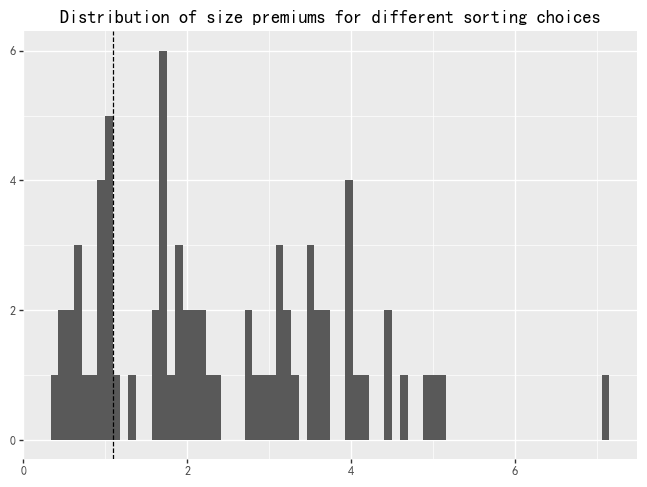

In [42]:
circulation_p_hacking_results_figure = (ggplot(circulation_p_hacking_results_n, aes(x="size_premium")) +
                                        geom_histogram(bins=len(circulation_p_hacking_results_n)) +
                                        labs(x="", y="",
                                             title="Distribution of size premiums for different sorting choices") +
                                             geom_vline(aes(xintercept=factors_ff3_monthly["smb1"].mean()*100), linetype="dashed")
                           )
circulation_p_hacking_results_figure.draw()

## 总市值

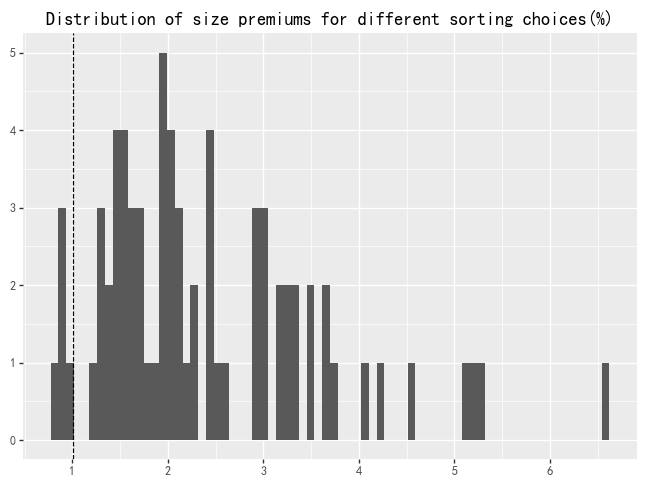

In [43]:
total_p_hacking_results_figure = (ggplot(total_p_hacking_results_n, aes(x="size_premium")) +
                                  geom_histogram(bins=len(total_p_hacking_results_n)) +
                                  labs(x="", y="",
                                       title="Distribution of size premiums for different sorting choices(%)") +
                                       geom_vline(aes(xintercept=factors_ff3_monthly["smb2"].mean()*100), linetype="dashed")
                           )
total_p_hacking_results_figure.draw()

# 8. Exercise

## 8.1

### 8.1.1 Which listing exchanges have the largest firms?

计算每个交易所中拥有最大1%市值（流通市值）的公司的数量

In [44]:
circulation_max_size_firm = (crsp_monthly.get(["month","exchange","Indnme","mktcap1"])
                                        .groupby("month",group_keys=False)
                                        .apply(lambda x: x.assign(mktcap_group = lambda x: np.digitize(x["mktcap1"], np.percentile(x["mktcap1"], [75, 90, 95, 99]))))
                                        .query("mktcap_group >= 4") ## select the firms with the largest market capitalization
                                        .groupby(["exchange"],group_keys=False)
                                        .apply(lambda x: x.assign(max_size_firm_num = len(x)).tail(1))
                                        .get(["exchange","max_size_firm_num"])
                                        .reset_index(drop=True)
                                        )
circulation_max_size_firm

,exchange,max_size_firm_num
0,上证A股,5858
1,创业板,171
2,深证A股,1445
3,科创板,11


计算各月市值（流通市值）最大的公司（在给定的交易所内），并且按市值从大到小排序

In [45]:
circulation_largest_firm = (crsp_monthly.get(["month","exchange","Indnme","mktcap1"])
                                        .groupby("month",group_keys=False)
                                        .apply(lambda x: x.assign(maxsize = max(x["mktcap1"])))
                                        .query("mktcap1==maxsize")
                                        .get(["month","exchange","mktcap1"])
                                        .sort_values("mktcap1",ascending=False)
                                        .reset_index(drop=True)
                                        )
circulation_largest_firm.head(10)

,month,exchange,mktcap1
0,2021-05-01,上证A股,2.786247e+09
1,2021-02-01,上证A股,2.666632e+09
2,2021-01-01,上证A股,2.658341e+09
3,2021-06-01,上证A股,2.583622e+09
4,2021-12-01,上证A股,2.575205e+09
5,2022-06-01,上证A股,2.568925e+09
6,2021-03-01,上证A股,2.523701e+09
7,2021-04-01,上证A股,2.520913e+09
8,2020-12-01,上证A股,2.509883e+09
9,2021-11-01,上证A股,2.425429e+09


计算每个交易所中拥有最大1%市值（总市值）的公司的数量

In [46]:
total_max_size_firm = (crsp_monthly.get(["month","exchange","Indnme","mktcap2"])
                                        .groupby("month",group_keys=False)
                                        .apply(lambda x: x.assign(mktcap_group = lambda x: np.digitize(x["mktcap2"], np.percentile(x["mktcap2"], [75, 90, 95, 99])))) ## please refer to appendix 1 and 2
                                        .query("mktcap_group >= 4") ## select the firms with the largest market capitalization
                                        .groupby(["exchange"],group_keys=False)
                                        .apply(lambda x: x.assign(max_size_firm_num = len(x)).tail(1))
                                        .get(["exchange","max_size_firm_num"])
                                        .reset_index(drop=True)
                                        )
total_max_size_firm

,exchange,max_size_firm_num
0,上证A股,5994
1,创业板,295
2,深证A股,1174
3,科创板,22


计算各月市值（总市值）最大的公司（在给定的交易所内），并且按市值从大到小排序

In [47]:
total_largest_firm = (crsp_monthly.get(["month","exchange","Indnme","mktcap2"])
                                        .groupby("month",group_keys=False)
                                        .apply(lambda x: x.assign(maxsize = max(x["mktcap2"])))
                                        .query("mktcap2==maxsize")
                                        .get(["month","exchange","mktcap2"])
                                        .sort_values("mktcap2",ascending=False)
                                        .reset_index(drop=True)
                                        )
total_largest_firm.head(10)

,month,exchange,mktcap2
0,2007-12-01,上证A股,5.013108e+09
1,2008-01-01,上证A股,4.091771e+09
2,2008-02-01,上证A股,3.654581e+09
3,2008-04-01,上证A股,2.925932e+09
4,2008-05-01,上证A股,2.901644e+09
5,2008-03-01,上证A股,2.788298e+09
6,2021-05-01,上证A股,2.786247e+09
7,2021-02-01,上证A股,2.666632e+09
8,2021-01-01,上证A股,2.658341e+09
9,2021-06-01,上证A股,2.583622e+09


每个月和每个交易所内，流通总市值最大组（即处于99%分位数以上的公司）的公司数量

In [48]:
circulation_plt_max_size_firm = (crsp_monthly.get(["month","exchange","Indnme","mktcap1"])
                                        .groupby("month",group_keys=False)
                                        .apply(lambda x: x.assign(mktcap_group = lambda x: np.digitize(x["mktcap1"], np.percentile(x["mktcap1"], [75, 90, 95, 99]))))
                                        .query("mktcap_group >= 4")
                                        .groupby(["month","exchange"],group_keys=False)
                                        .apply(lambda x: x.assign(num = len(x)))
                                        )
circulation_plt_max_size_firm

,month,exchange,Indnme,mktcap1,mktcap_group,num
0,1992-02-01,深证A股,金融,1.419400e+06,4,1
1,1992-03-01,深证A股,金融,1.758845e+06,4,1
2,1992-04-01,深证A股,金融,2.599445e+06,4,1
10,1992-12-01,深证A股,金融,3.004553e+06,4,1
11,1993-01-01,深证A股,金融,3.301633e+06,4,1
...,...,...,...,...,...,...
710658,2023-09-01,科创板,公用事业,1.712060e+08,4,1
715777,2024-10-01,科创板,公用事业,1.893584e+08,4,2
715778,2024-11-01,科创板,公用事业,2.341932e+08,4,2
728675,2024-10-01,科创板,工业,1.728481e+08,4,2


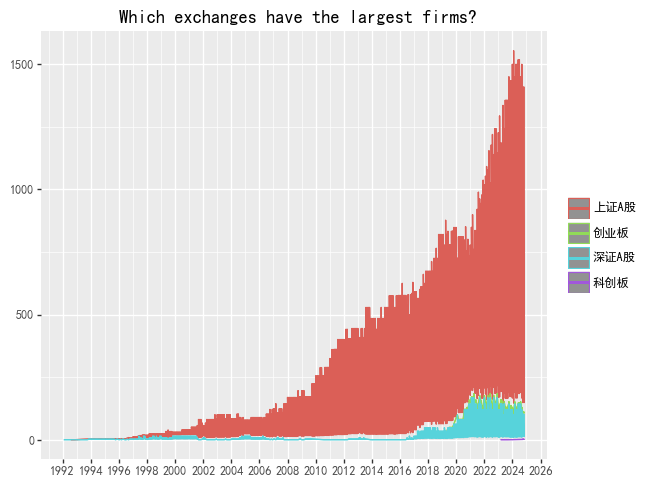

In [49]:
plt_circulation_plt_max_size_firm=(ggplot(circulation_plt_max_size_firm,
                                      aes(x="month",y="num",color="exchange"))+
                                      geom_area(position="stack", stat="identity", alpha=0.5)+
                                      geom_line(position="stack") +
                                      scale_x_datetime(breaks=date_breaks("2 year"), labels=date_format("%Y")) +
                                      labs(x="", y="", color="", linetype="", 
                                           title=" Which exchanges have the largest firms?")+
                                           theme(legend_title=element_blank()))

plt_circulation_plt_max_size_firm.draw()

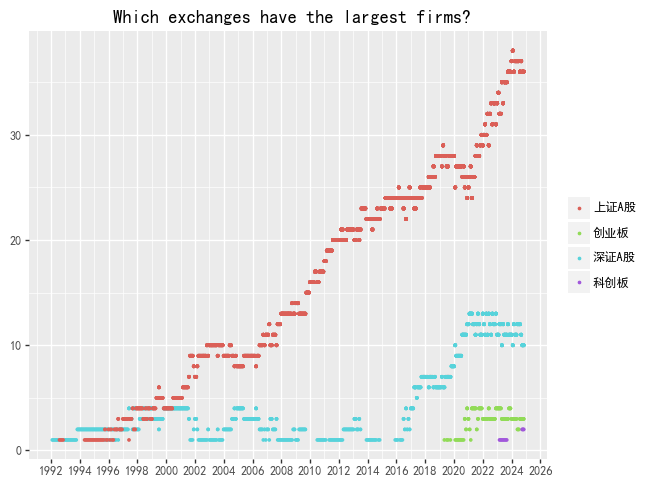

In [50]:
plt_circulation_plt_max_size_firm_2=(ggplot(circulation_plt_max_size_firm,
                                      aes(x="month",y="num",color="exchange"))+
                                      geom_point(size=0.5)+
                                      scale_x_datetime(breaks=date_breaks("2 year"), labels=date_format("%Y")) +
                                      labs(x="", y="", color="", linetype="", 
                                           title=" Which exchanges have the largest firms?")+
                                           theme(legend_title=element_blank()))
plt_circulation_plt_max_size_firm_2.draw()

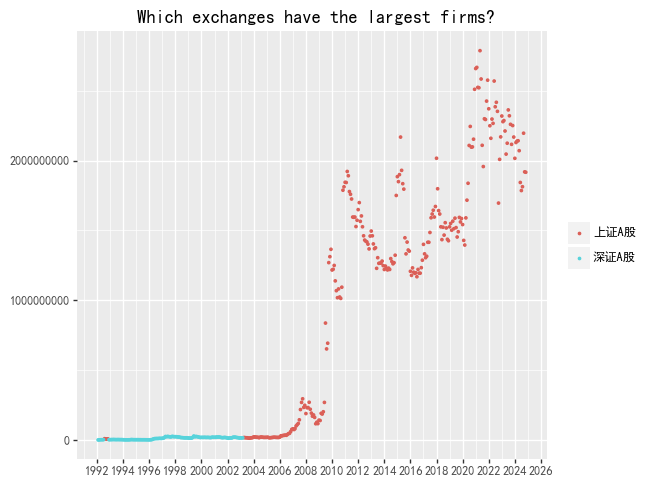

In [51]:
plt_circulation_plt_max_size_firm_3=(ggplot(circulation_largest_firm,
                                      aes(x="month",y="mktcap1",color="exchange"))+
                                      geom_point(size=0.5)+
                                      scale_x_datetime(breaks=date_breaks("2 year"), labels=date_format("%Y")) +
                                      labs(x="", y="", color="", linetype="", 
                                           title=" Which exchanges have the largest firms?")+
                                           theme(legend_title=element_blank()))
plt_circulation_plt_max_size_firm_3.draw()

每个月和每个交易所内，总市值最大组（即处于99%分位数以上的公司）的公司数量

In [52]:
total_plt_max_size_firm = (crsp_monthly.get(["month","exchange","Indnme","mktcap2"])
                                        .groupby("month",group_keys=False)
                                        .apply(lambda x: x.assign(mktcap_group = lambda x: np.digitize(x["mktcap2"], np.percentile(x["mktcap2"], [75, 90, 95, 99]))))
                                        .query("mktcap_group >= 4")
                                        .groupby(["month","exchange"],group_keys=False)
                                        .apply(lambda x: x.assign(num = len(x)))
                                        )
total_plt_max_size_firm

,month,exchange,Indnme,mktcap2,mktcap_group,num
0,1992-02-01,深证A股,金融,2.831664e+06,4,1
1,1992-03-01,深证A股,金融,3.508847e+06,4,1
51,1996-05-01,深证A股,金融,1.267342e+07,4,1
54,1996-08-01,深证A股,金融,1.693582e+07,4,1
59,1997-01-01,深证A股,金融,1.990503e+07,4,1
...,...,...,...,...,...,...
710656,2023-07-01,科创板,公用事业,1.873753e+08,4,1
710657,2023-08-01,科创板,公用事业,1.821949e+08,4,1
715777,2024-10-01,科创板,公用事业,1.893584e+08,4,2
715778,2024-11-01,科创板,公用事业,2.341932e+08,4,2


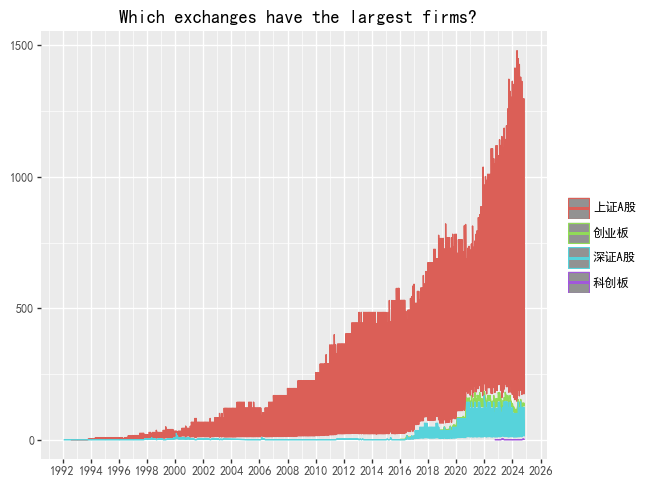

In [53]:
plt_total_plt_max_size_firm=(ggplot(total_plt_max_size_firm,
                                      aes(x="month",y="num",color="exchange"))+
                                      geom_area(position="stack", stat="identity", alpha=0.5)+
                                      geom_line(position="stack") +
                                      scale_x_datetime(breaks=date_breaks("2 year"), labels=date_format("%Y")) +
                                      labs(x="", y="", color="", linetype="", 
                                           title=" Which exchanges have the largest firms?")+
                                           theme(legend_title=element_blank()))

plt_total_plt_max_size_firm.draw()

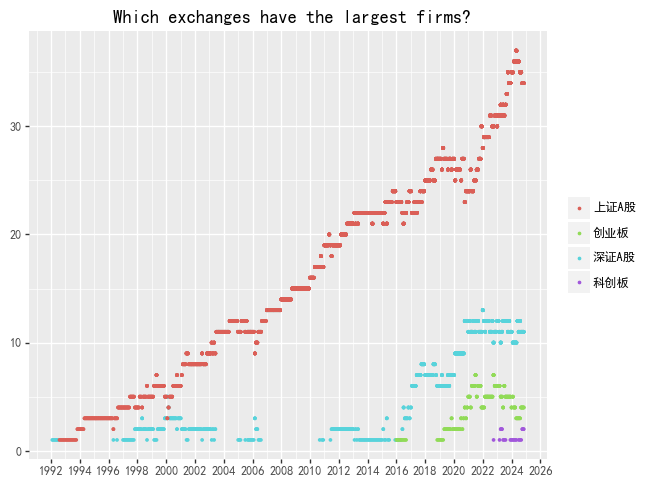

In [54]:
plt_total_plt_max_size_firm_2=(ggplot(total_plt_max_size_firm,
                                      aes(x="month",y="num",color="exchange"))+
                                      geom_point(size=0.5)+
                                      scale_x_datetime(breaks=date_breaks("2 year"), labels=date_format("%Y")) +
                                      labs(x="", y="", color="", linetype="", 
                                           title=" Which exchanges have the largest firms?")+
                                           theme(legend_title=element_blank()))

plt_total_plt_max_size_firm_2.draw()

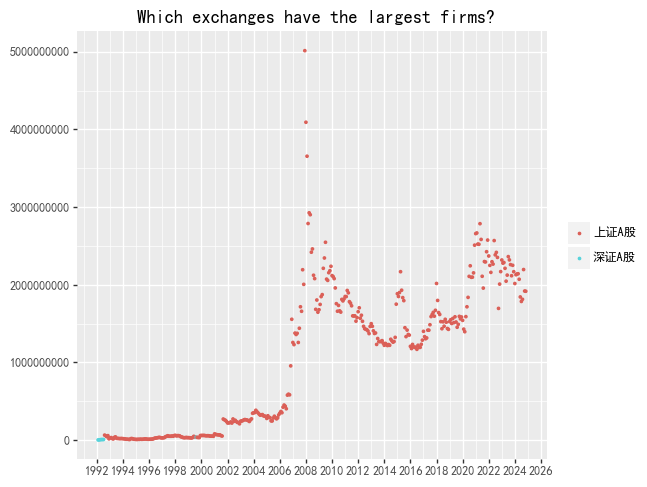

In [55]:
total_plt_max_size_firm_3=(ggplot(total_largest_firm,
                                      aes(x="month",y="mktcap2",color="exchange"))+
                                      geom_point(size=0.5)+
                                      scale_x_datetime(breaks=date_breaks("2 year"), labels=date_format("%Y")) +
                                      labs(x="", y="", color="", linetype="", 
                                           title=" Which exchanges have the largest firms?")+
                                           theme(legend_title=element_blank()))
total_plt_max_size_firm_3.draw()

### 8.1.2 . Which listing industries have the largest firms?

In [56]:
circulation_max_size_firm_industries = (crsp_monthly.get(["month","exchange","Indnme","mktcap1"])
                                        .groupby("month",group_keys=False)
                                        .apply(lambda x: x.assign(mktcap_group = lambda x: np.digitize(x["mktcap1"], np.percentile(x["mktcap1"], [75, 90, 95, 99]))))
                                        .query("mktcap_group >= 4") ## select the firms with the largest market capitalization
                                        .groupby(["Indnme"],group_keys=False)
                                        .apply(lambda x: x.assign(max_size_firm_num = len(x)).tail(1))
                                        .get(["Indnme","max_size_firm_num"])
                                        .reset_index(drop=True)
                                        )
circulation_max_size_firm_industries

,Indnme,max_size_firm_num
0,公用事业,557
1,商业,49
2,工业,3244
3,房地产,426
4,综合,90
5,金融,3119


In [57]:
circulation_largest_firm_industries = (crsp_monthly.get(["month","exchange","Indnme","mktcap1"])
                                        .groupby("month",group_keys=False)
                                        .apply(lambda x: x.assign(maxsize = max(x["mktcap1"])))
                                        .query("mktcap1==maxsize")
                                        .get(["month","Indnme","mktcap1"])
                                        .sort_values("mktcap1",ascending=False)
                                        .reset_index(drop=True)
                                        )
circulation_largest_firm_industries.head(10)

,month,Indnme,mktcap1
0,2021-05-01,工业,2.786247e+09
1,2021-02-01,工业,2.666632e+09
2,2021-01-01,工业,2.658341e+09
3,2021-06-01,工业,2.583622e+09
4,2021-12-01,工业,2.575205e+09
5,2022-06-01,工业,2.568925e+09
6,2021-03-01,工业,2.523701e+09
7,2021-04-01,工业,2.520913e+09
8,2020-12-01,工业,2.509883e+09
9,2021-11-01,工业,2.425429e+09


In [58]:
total_max_size_firm_industries = (crsp_monthly.get(["month","exchange","Indnme","mktcap2"])
                                        .groupby("month",group_keys=False)
                                        .apply(lambda x: x.assign(mktcap_group = lambda x: np.digitize(x["mktcap2"], np.percentile(x["mktcap2"], [75, 90, 95, 99]))))
                                        .query("mktcap_group >= 4") ## select the firms with the largest market capitalization
                                        .groupby(["Indnme"],group_keys=False)
                                        .apply(lambda x: x.assign(max_size_firm_num = len(x)).tail(1))
                                        .get(["Indnme","max_size_firm_num"])
                                        .reset_index(drop=True)
                                        )
total_max_size_firm_industries

,Indnme,max_size_firm_num
0,公用事业,621
1,商业,6
2,工业,3313
3,房地产,319
4,综合,80
5,金融,3146


In [59]:
total_largest_firm_industries = (crsp_monthly.get(["month","exchange","Indnme","mktcap2"])
                                        .groupby("month",group_keys=False)
                                        .apply(lambda x: x.assign(maxsize = max(x["mktcap2"])))
                                        .query("mktcap2==maxsize")
                                        .get(["month","Indnme","mktcap2"])
                                        .sort_values("mktcap2",ascending=False)
                                        .reset_index(drop=True)
                                        )
total_largest_firm_industries.head(10)

,month,Indnme,mktcap2
0,2007-12-01,工业,5.013108e+09
1,2008-01-01,工业,4.091771e+09
2,2008-02-01,工业,3.654581e+09
3,2008-04-01,工业,2.925932e+09
4,2008-05-01,工业,2.901644e+09
5,2008-03-01,工业,2.788298e+09
6,2021-05-01,工业,2.786247e+09
7,2021-02-01,工业,2.666632e+09
8,2021-01-01,工业,2.658341e+09
9,2021-06-01,工业,2.583622e+09


In [60]:
circulation_plt_largest_firm_industries = (crsp_monthly.get(["month","exchange","Indnme","mktcap1"])
                                        .groupby("month",group_keys=False)
                                        .apply(lambda x: x.assign(mktcap_group = lambda x: np.digitize(x["mktcap1"], np.percentile(x["mktcap1"], [75, 90, 95, 99]))))
                                        .query("mktcap_group >= 4")
                                        .groupby(["month","Indnme"],group_keys=False)
                                        .apply(lambda x: x.assign(num = len(x)))
                                        )
circulation_plt_largest_firm_industries

,month,exchange,Indnme,mktcap1,mktcap_group,num
0,1992-02-01,深证A股,金融,1.419400e+06,4,1
1,1992-03-01,深证A股,金融,1.758845e+06,4,1
2,1992-04-01,深证A股,金融,2.599445e+06,4,1
10,1992-12-01,深证A股,金融,3.004553e+06,4,1
11,1993-01-01,深证A股,金融,3.301633e+06,4,1
...,...,...,...,...,...,...
710658,2023-09-01,科创板,公用事业,1.712060e+08,4,6
715777,2024-10-01,科创板,公用事业,1.893584e+08,4,5
715778,2024-11-01,科创板,公用事业,2.341932e+08,4,5
728675,2024-10-01,科创板,工业,1.728481e+08,4,29


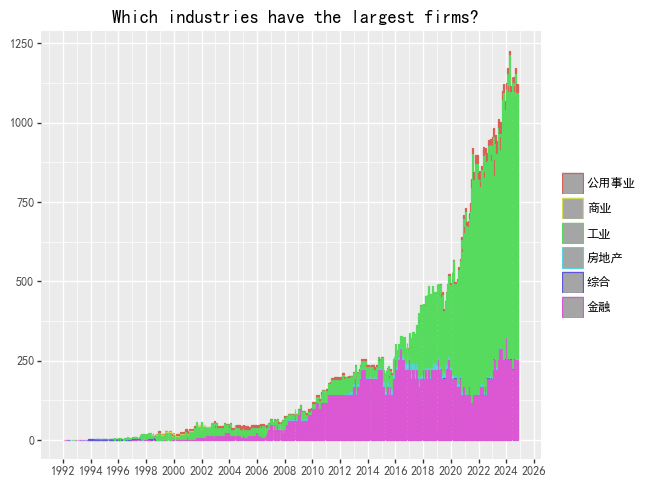

In [61]:
plt_circulation_plt_largest_firm_industries=(ggplot(circulation_plt_largest_firm_industries,
                                      aes(x="month",y="num",color="Indnme"))+
                                      geom_bar(stat="identity", alpha=0.5)+
                                      scale_x_datetime(breaks=date_breaks("2 year"), labels=date_format("%Y")) +
                                      labs(x="", y="", color="", linetype="", 
                                           title=" Which industries have the largest firms?")+
                                           theme(legend_title=element_blank()))

plt_circulation_plt_largest_firm_industries.draw()

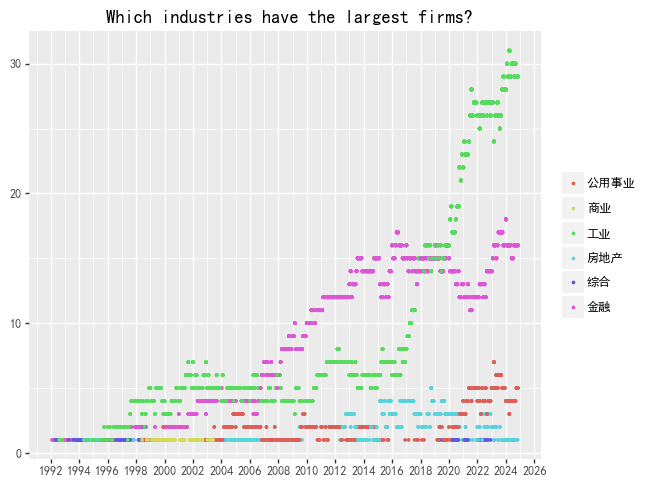

In [62]:
plt_circulation_plt_largest_firm_industries_2=(ggplot(circulation_plt_largest_firm_industries,
                                      aes(x="month",y="num",color="Indnme"))+
                                      geom_point(size=0.5)+
                                      scale_x_datetime(breaks=date_breaks("2 year"), labels=date_format("%Y")) +
                                      labs(x="", y="", color="", linetype="", 
                                           title=" Which industries have the largest firms?")+
                                           theme(legend_title=element_blank()))

plt_circulation_plt_largest_firm_industries_2.draw()

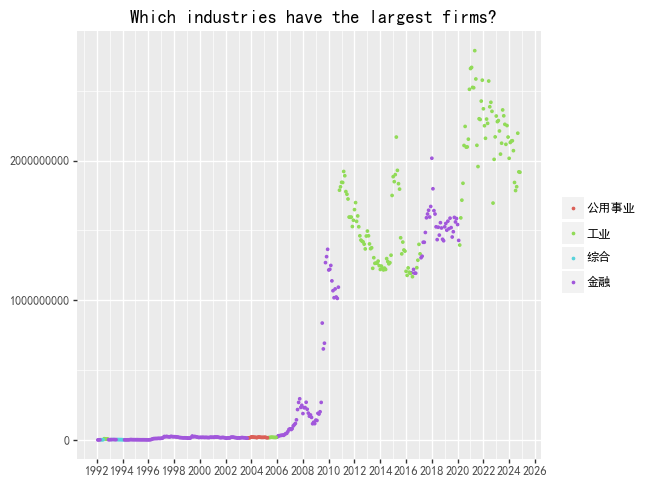

In [63]:
plt_circulation_plt_largest_firm_industries_3=(ggplot(circulation_largest_firm_industries,
                                      aes(x="month",y="mktcap1",color="Indnme"))+
                                      geom_point(size=0.5)+
                                      scale_x_datetime(breaks=date_breaks("2 year"), labels=date_format("%Y")) +
                                      labs(x="", y="", color="", linetype="", 
                                           title=" Which industries have the largest firms?")+
                                           theme(legend_title=element_blank()))
plt_circulation_plt_largest_firm_industries_3.draw()

In [64]:
total_plt_largest_firm_industries = (crsp_monthly.get(["month","exchange","Indnme","mktcap2"])
                                        .groupby("month",group_keys=False)
                                        .apply(lambda x: x.assign(mktcap_group = lambda x: np.digitize(x["mktcap2"], np.percentile(x["mktcap2"], [75, 90, 95, 99]))))
                                        .query("mktcap_group >= 4")
                                        .groupby(["month","Indnme"],group_keys=False)
                                        .apply(lambda x: x.assign(num = len(x)))
                                        )
total_plt_largest_firm_industries

,month,exchange,Indnme,mktcap2,mktcap_group,num
0,1992-02-01,深证A股,金融,2.831664e+06,4,1
1,1992-03-01,深证A股,金融,3.508847e+06,4,1
51,1996-05-01,深证A股,金融,1.267342e+07,4,1
54,1996-08-01,深证A股,金融,1.693582e+07,4,1
59,1997-01-01,深证A股,金融,1.990503e+07,4,1
...,...,...,...,...,...,...
710656,2023-07-01,科创板,公用事业,1.873753e+08,4,7
710657,2023-08-01,科创板,公用事业,1.821949e+08,4,7
715777,2024-10-01,科创板,公用事业,1.893584e+08,4,6
715778,2024-11-01,科创板,公用事业,2.341932e+08,4,5


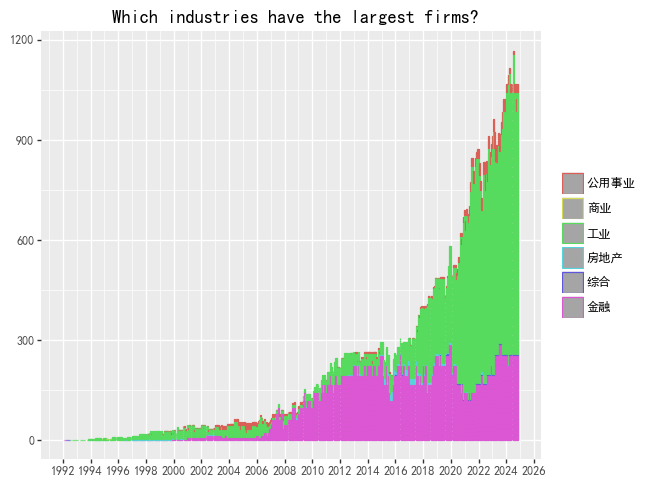

In [65]:
plt_total_plt_largest_firm_industries=(ggplot(total_plt_largest_firm_industries,
                                      aes(x="month",y="num",color="Indnme"))+
                                      geom_bar(stat="identity", alpha=0.5)+
                                      scale_x_datetime(breaks=date_breaks("2 year"), labels=date_format("%Y")) +
                                      labs(x="", y="", color="", linetype="", 
                                           title=" Which industries have the largest firms?")+
                                           theme(legend_title=element_blank()))

plt_total_plt_largest_firm_industries.draw()

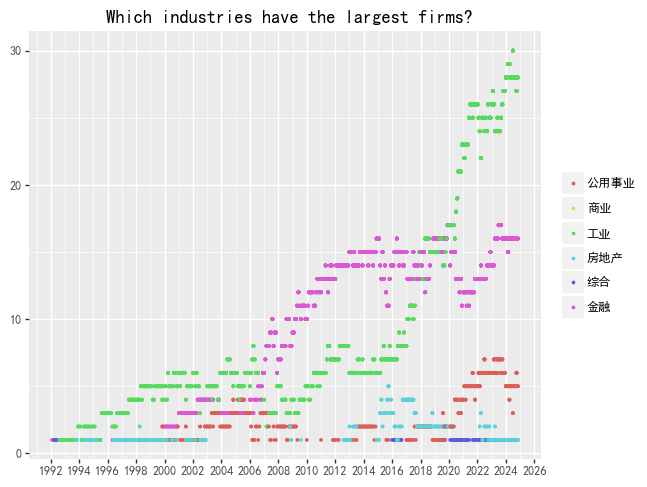

In [66]:
plt_total_plt_largest_firm_industries_2=(ggplot(total_plt_largest_firm_industries,
                                      aes(x="month",y="num",color="Indnme"))+
                                      geom_point(size=0.5)+
                                      scale_x_datetime(breaks=date_breaks("2 year"), labels=date_format("%Y")) +
                                      labs(x="", y="", color="", linetype="", 
                                           title=" Which industries have the largest firms?")+
                                           theme(legend_title=element_blank()))

plt_total_plt_largest_firm_industries_2.draw()

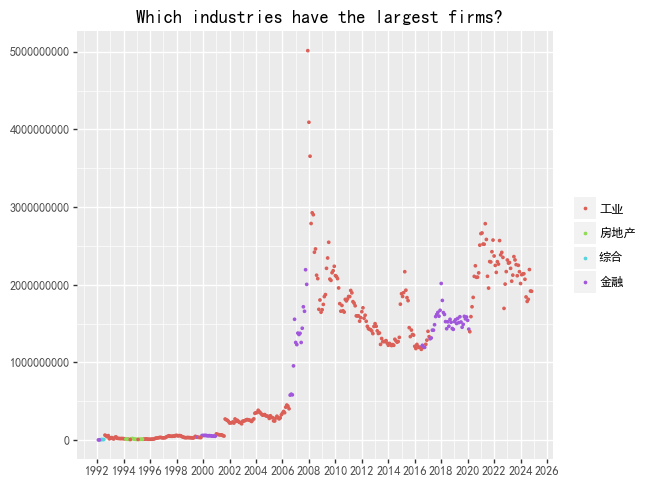

In [67]:
plt_total_plt_largest_firm_industries_3=(ggplot(total_largest_firm_industries,
                                      aes(x="month",y="mktcap2",color="Indnme"))+
                                      geom_point(size=0.5)+
                                      scale_x_datetime(breaks=date_breaks("2 year"), labels=date_format("%Y")) +
                                      labs(x="", y="", color="", linetype="", 
                                           title=" Which industries have the largest firms?")+
                                           theme(legend_title=element_blank()))
plt_total_plt_largest_firm_industries_3.draw()

### 8.1.3 Conclusion

1.无论以总市值计，还是以流通市值计，上证A股具有最多的1%公司规模月度数量，且大于深证A股、创业板与科创板的数量之和。

2.工业具有最多的1%公司规模月度数量，为3244家。金融业其次，为3119家。这两个行业显著领先于公用事业、商业、房地产等其他行业。其中，2020年至今，金融业有所萎靡，工业持续领跑最大1%规模企业月度数量。

## 8.2

### 8.2.1 Generate Ten Size Portfolios and Calculate the Size Rremium

In [68]:
circulation_breakpoints = circulation_crsp_monthly.groupby("month")['mktcap1_lag'].quantile(q=np.linspace(0, 1, 11)).unstack()
circulation_breakpoints.columns = [f"breakpoint{i+1}"for i in range(11)]
circulation_crsp_monthly.groupby("month")['mktcap1_lag'].quantile(q=np.linspace(0, 1, 11))

month          
1992-02-01  0.0    2.291100e+04
            0.1    5.379360e+04
            0.2    5.924500e+04
            0.3    8.098800e+04
            0.4    9.498600e+04
                       ...     
2024-11-01  0.6    5.949603e+06
            0.7    8.273313e+06
            0.8    1.308465e+07
            0.9    2.505372e+07
            1.0    1.919206e+09
Name: mktcap1_lag, Length: 4334, dtype: float64

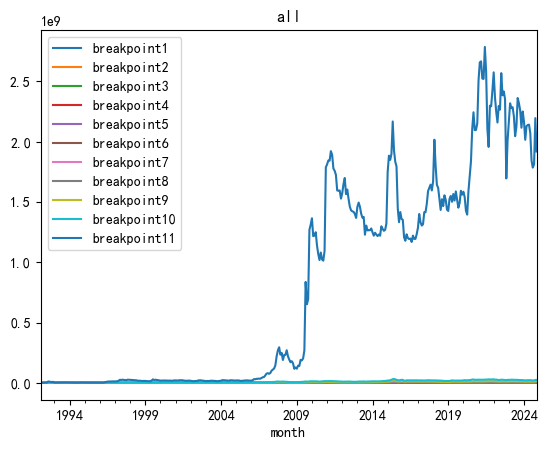

In [69]:
circulation_breakpoints.plot(y=list(circulation_breakpoints.columns[:]), title='all')
plt.show()

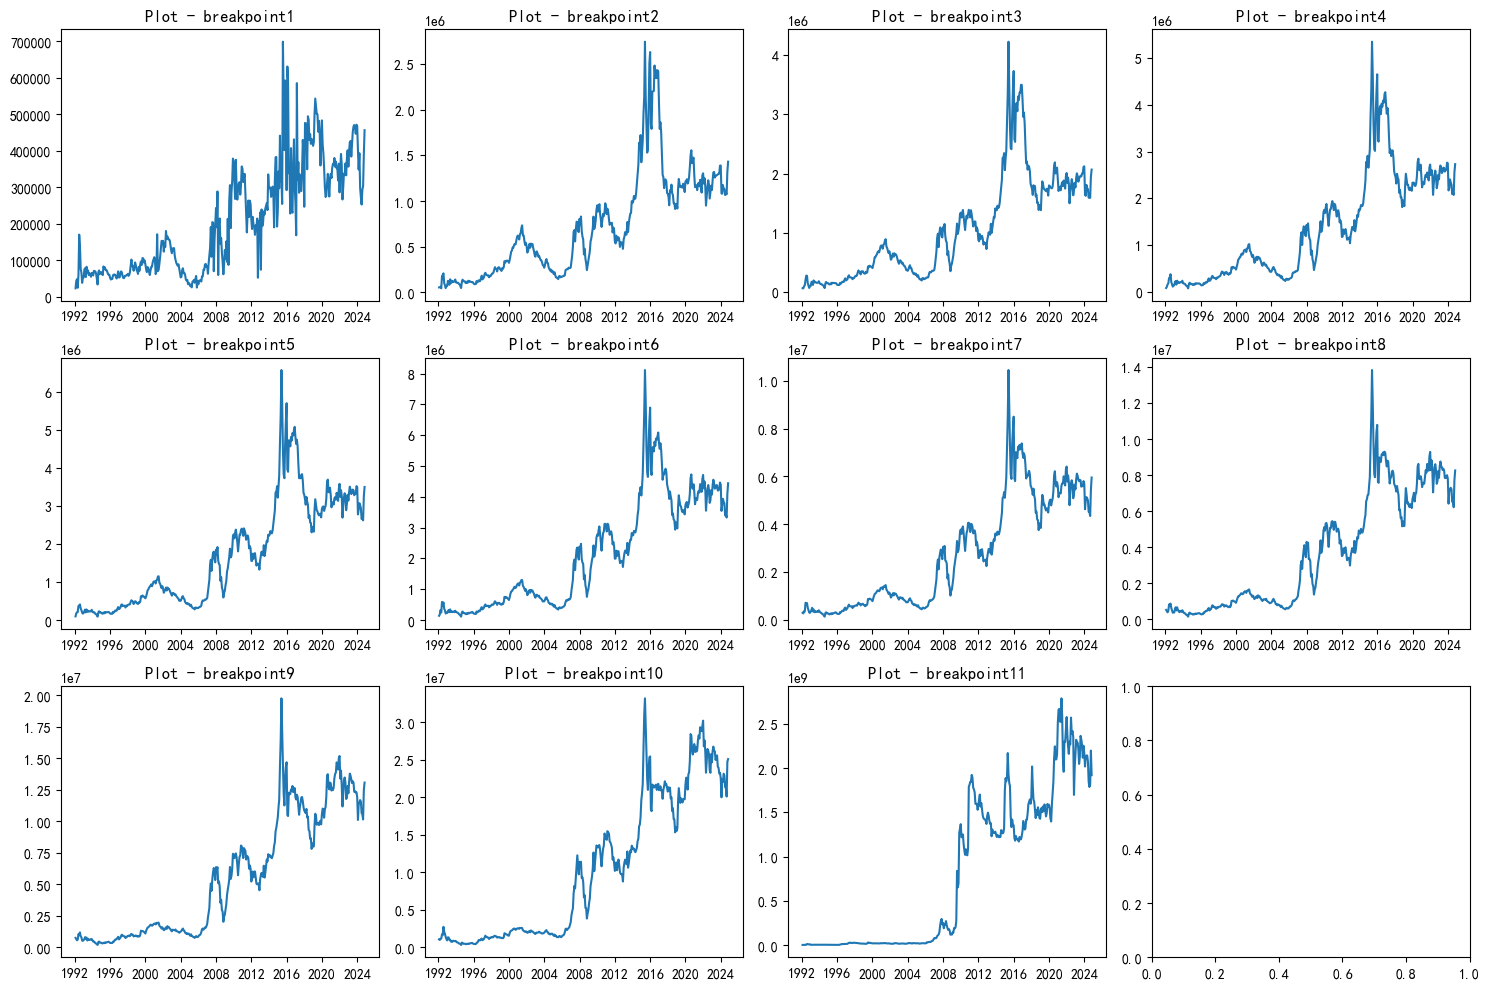

In [70]:
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
axs = axs.flatten()
for i, column in enumerate(circulation_breakpoints.columns[:]):
    axs[i].plot(circulation_breakpoints.index, circulation_breakpoints[column])
    axs[i].set_title(f'Plot - {column}')
plt.tight_layout()

plt.show()

In [71]:
def compute_portfolio_returns_2(n_portfolios = 10,exchanges = ["上证A股", "深证A股", "创业板", "科创板"],
                              value_weighted = True,data = crsp_monthly,ret_excess = "ret_excess1",mktcap_lag = "mktcap1_lag"):
    if exchanges == ["创业板"]:
        data = data.query("exchange == '创业板'") ## select the data of the selected exchanges
    if exchanges == ["科创板"]:
        data = data.query("exchange == '科创板'")

    if data.empty:
        return -1

    returns_df = (data.groupby("month",group_keys=False)
               .apply(lambda x: x.assign(portfolio = assign_portfolio(x,exchanges=exchanges, n_portfolios=n_portfolios, mktcap_lag=mktcap_lag))) ## assign the portfolio
               .groupby(["month","portfolio"],group_keys=False)
               .apply(lambda x: np.where(value_weighted,
                                         np.average(x[ret_excess],weights=x[mktcap_lag]),
                                         np.mean(x[ret_excess])))  ## if value_weighted, calculate the weighted average, otherwise calculate the mean
               .reset_index(name="ret")
               .groupby("month",group_keys=False)
               .apply(lambda x: x.assign(min_size_ret = np.nanmean(x["ret"][x["portfolio"]==x["portfolio"].min()]),
                                         max_size_ret = np.nanmean(x["ret"][x["portfolio"]==x["portfolio"].max()])
                                        )
                     .tail(1)) ## for the all the companies in a same month, they have the same value,thus we only need the last value
               
               .assign(size_premium = lambda x: x["min_size_ret"]-x["max_size_ret"]) ## long small cap and short large cap
               .reset_index(drop=True)
               .get(["month","size_premium"])
               )

    return returns_df

In [72]:
circulation_ret_all_2 = compute_portfolio_returns_2(n_portfolios=10,
                                    exchanges=["上证A股", "深证A股", "创业板", "科创板"],
                                    value_weighted=True,
                                    data=circulation_crsp_monthly,
                                    ret_excess = "ret_excess1",
                                    mktcap_lag="mktcap1_lag")

circulation_ret_all_2.sort_values("size_premium",ascending=False)

,month,size_premium
3,1992-05-01,561.063187
0,1992-02-01,84.701200
279,2015-05-01,74.158568
14,1993-04-01,62.700339
30,1994-08-01,60.883680
...,...,...
52,1996-06-01,-20.605684
51,1996-05-01,-21.387753
8,1992-10-01,-24.123310
274,2014-12-01,-40.289700


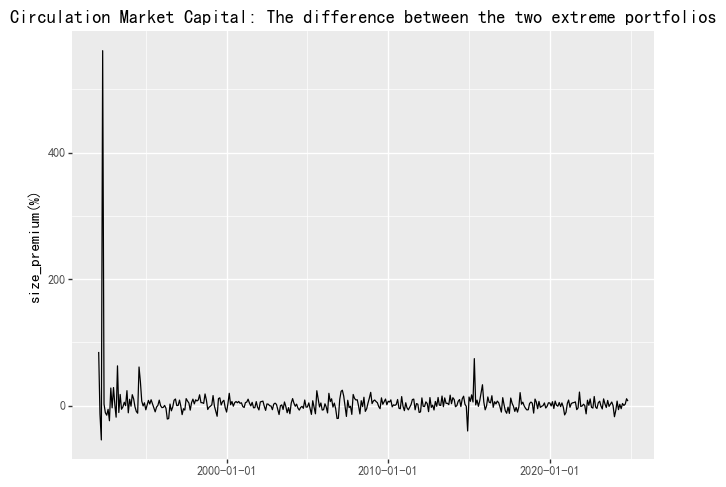

In [73]:
circulation_mkt_portfolios_plt = (ggplot(circulation_ret_all_2,
                              aes(x="month",y="size_premium"))+
                              geom_line()+
                              scale_y_continuous() +
                              scale_x_date(name="") +
                              labs(x="month", y="size_premium(%)",
                            title="Circulation Market Capital: The difference between the two extreme portfolios"))

circulation_mkt_portfolios_plt.draw()

In [74]:
total_breakpoints = total_crsp_monthly.groupby("month")['mktcap2_lag'].quantile(q=np.linspace(0, 1, 11)).unstack()
total_breakpoints.columns = [f"breakpoint{i+1}"for i in range(11)]
total_crsp_monthly.groupby("month")['mktcap2_lag'].quantile(q=np.linspace(0, 1, 11))

month          
1992-02-01  0.0    8.175000e+04
            0.1    9.660000e+04
            0.2    9.885000e+04
            0.3    1.342625e+05
            0.4    1.645100e+05
                       ...     
2024-11-01  0.6    7.033100e+06
            0.7    9.719516e+06
            0.8    1.482346e+07
            0.9    2.757209e+07
            1.0    1.919206e+09
Name: mktcap2_lag, Length: 4334, dtype: float64

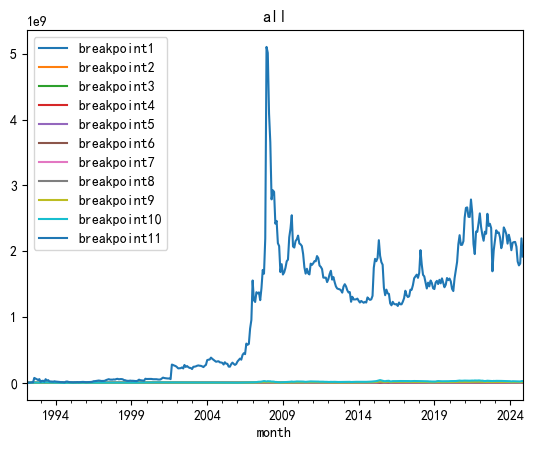

In [75]:
total_breakpoints.plot(y=list(total_breakpoints.columns[:]), title='all')
plt.show()

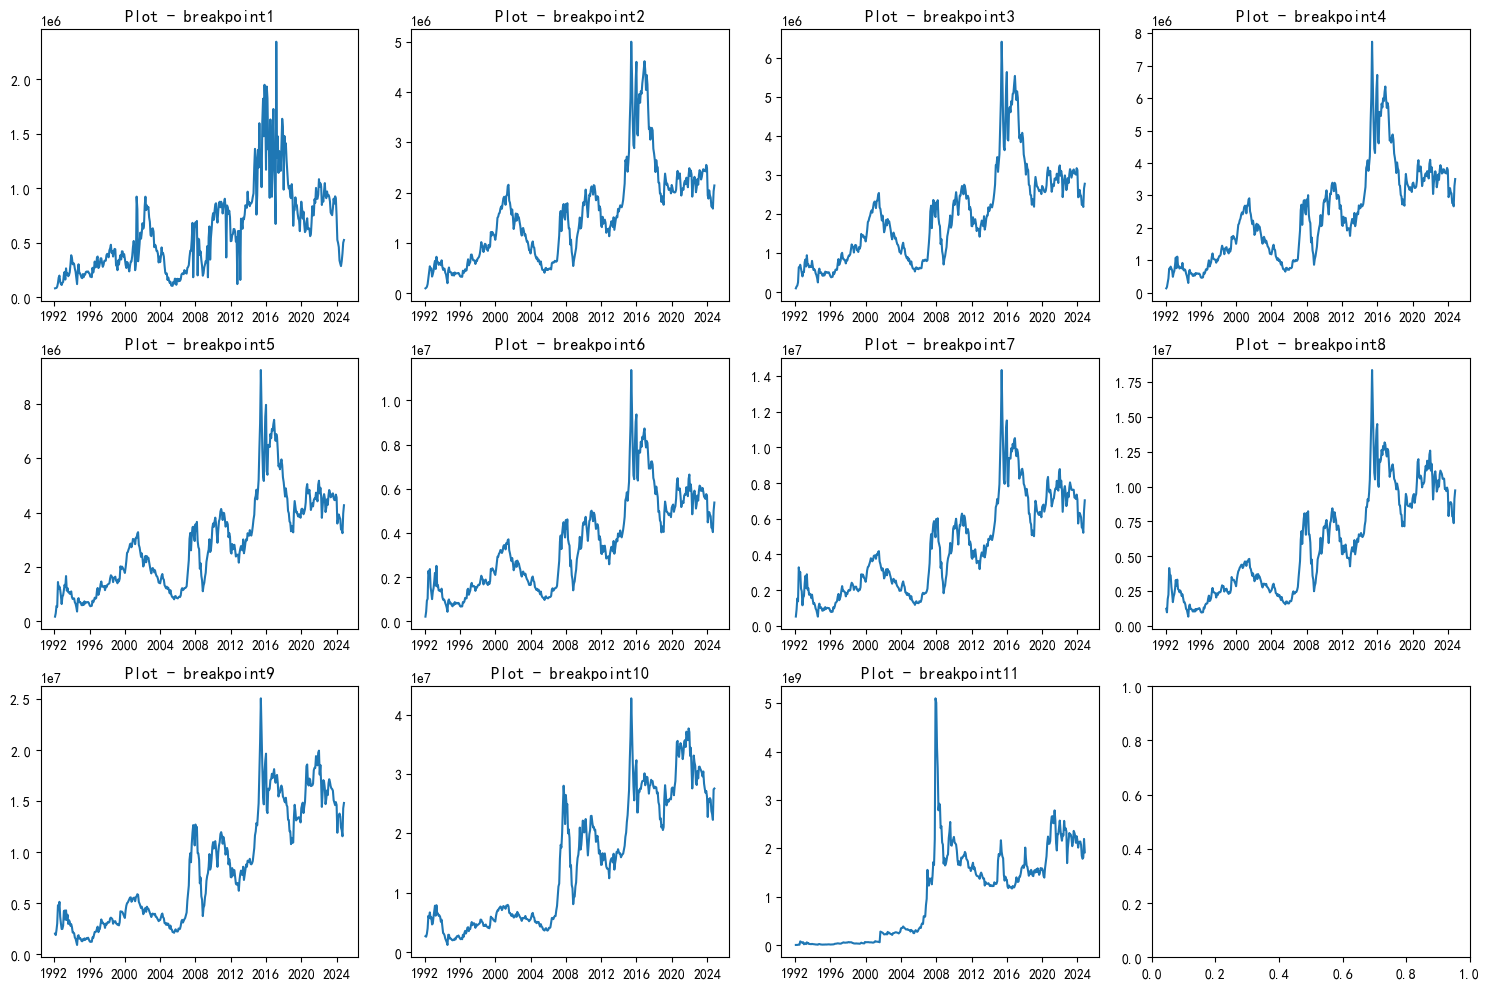

In [76]:
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
axs = axs.flatten()
for i, column in enumerate(total_breakpoints.columns[:]):
    axs[i].plot(total_breakpoints.index, total_breakpoints[column])
    axs[i].set_title(f'Plot - {column}')
plt.tight_layout()

plt.show()

In [77]:
total_ret_all_2 = compute_portfolio_returns_2(n_portfolios=10,
                                    exchanges=["上证A股", "深证A股", "创业板", "科创板"],
                                    value_weighted=True,
                                    data=total_crsp_monthly,
                                    ret_excess = "ret_excess1",
                                    mktcap_lag="mktcap2_lag")

total_ret_all_2.sort_values("size_premium",ascending=False)

,month,size_premium
14,1993-04-01,88.138380
279,2015-05-01,68.124722
3,1992-05-01,47.631850
31,1994-09-01,32.390774
180,2007-02-01,26.532233
...,...,...
1,1992-03-01,-24.828420
52,1996-06-01,-26.223749
178,2006-12-01,-31.391990
274,2014-12-01,-35.385287


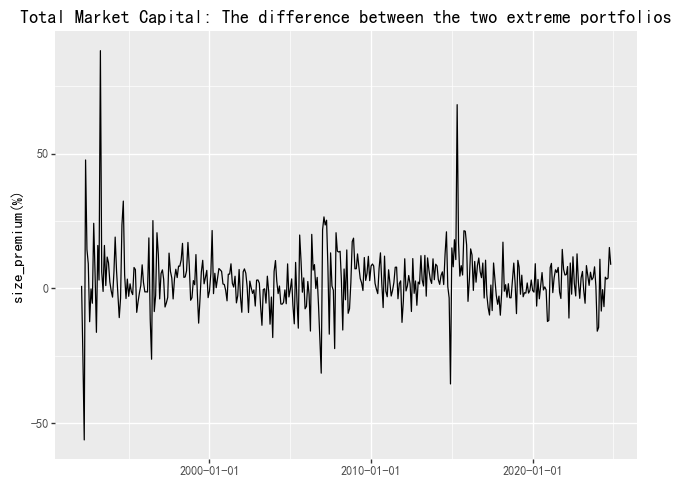

In [78]:
total_mkt_portfolios_plt = (ggplot(total_ret_all_2,
                              aes(x="month",y="size_premium"))+
                              geom_line()+
                              scale_y_continuous() +
                              scale_x_date(name="") +
                              labs(x="month", y="size_premium(%)",
                            title="Total Market Capital: The difference between the two extreme portfolios"))

total_mkt_portfolios_plt.draw()

### 8.2.2 Conclusion

1.随着分位数的提升，规模组合的市值（无论是总市值还是流动市值）波动逐渐温和，且在2009年后开始急剧震荡上升。但对于总市值1%的规模组合而言，2009年经历急剧攀升后又出现剧烈回调，此后波动较为平缓。

2.经过加权调整后，1992年5月存在异常规模溢价（流通市值），size-premium为561.06。最小规模溢价出现在1992年4月，下探至-54.45。总体而言，规模溢价在理历年相对平稳。

## 8.3 Calculate CAPM alpha and beta instead of the average excess return

### 8.3.1 Change the function

In [ ]:


def compute_portfolio_returns_3(n_portfolios = 10,exchanges = ["上证A股", "深证A股", "创业板", "科创板"],
                              value_weighted = True,data = crsp_monthly,ret_excess = "ret_excess1",mktcap_lag = "mktcap1_lag",
                              mkt_excess_choice = "mkt_excess1"):
    if exchanges == ["创业板"]:
        data = data.query("exchange == '创业板'") ## select the data of the selected exchanges
    if exchanges == ["科创板"]:
        data = data.query("exchange == '科创板'")

    
    mkt_excess = factors_ff3_monthly.get(["month",mkt_excess_choice])
    mkt_excess.columns = ["month","mkt_excess"]

    returns_df = (data.groupby("month",group_keys=False)
               .apply(lambda x: x.assign(portfolio = assign_portfolio(x,exchanges=exchanges, n_portfolios=n_portfolios, mktcap_lag=mktcap_lag))) ## assign the portfolio
               .groupby(["month","portfolio"],group_keys=False)
               .apply(lambda x: np.where(value_weighted,
                                         np.average(x[ret_excess],weights=x[mktcap_lag]),
                                         np.mean(x[ret_excess])))  ## if value_weighted, calculate the weighted average, otherwise calculate the mean
               .reset_index(name="ret")
               .assign(ret = lambda x: x["ret"].astype(float)) 
               .pivot(index="month",
                    columns="portfolio",
                    values="ret")
                ## result:
                ## month    1         2         3         4         5         6         7         8         9         10
                ## 2010-01  0.01      0.02      0.03      0.04      0.05      0.06      0.07      0.08      0.09      0.10

                .reset_index()
                .assign(long_short = lambda x: x[1]-x[n_portfolios])
                .melt(id_vars="month",
                      var_name="type",
                      value_name="ret")
                ## result:
                ## month    type      ret
                ## 2010-01  1         0.01
                ## 2010-01  2         0.02
                
                .merge(mkt_excess,
                   how="left",
                   on="month")
                .groupby("type",group_keys=False)
                ## ret_excess = alpha + beta * mkt_excess + error ( ret - mkt_excess = alpha + beta * (mkt_ret - mkt_excess) + error )
                ## HAC is used to correct the standard error using Newey-West method
                ## maxlags is the number of lags to consider in the Newey-West method, we choose 6 as an appropriate number
                .apply(lambda x: x.assign(alpha = sm.OLS.from_formula(formula="ret~1+mkt_excess", data=x).fit(cov_type="HAC", cov_kwds={"maxlags": 6}).params[0],
                                       alpha_t = sm.OLS.from_formula(formula="ret~1+mkt_excess", data=x).fit(cov_type="HAC", cov_kwds={"maxlags": 6}).tvalues[0],
                                       beta = sm.OLS.from_formula(formula="ret~1+mkt_excess", data=x).fit(cov_type="HAC", cov_kwds={"maxlags": 6}).params[1],
                                       beta_t = sm.OLS.from_formula(formula="ret~1+mkt_excess", data=x).fit(cov_type="HAC", cov_kwds={"maxlags": 6}).tvalues[1],
                                       premium = np.mean(x["ret"]),
                                       ## ret_excess = c + error
                                       t_value = sm.OLS.from_formula(formula="ret ~ 1",data=x).fit(cov_type="HAC", cov_kwds={"maxlags": 6}).tvalues[0]
                                       )
                                       .tail(1)
                           )
            .drop(["month","ret","mkt_excess"], axis=1)
               )

    return returns_df

### 8.3.2 流动市值

In [126]:
compute_portfolio_returns_3(n_portfolios=10,
                            exchanges = ["上证A股", "深证A股", "创业板", "科创板"],
                            value_weighted=True,
                            data=circulation_crsp_monthly,
                            ret_excess="ret_excess1",
                            mktcap_lag="mktcap1_lag",
                            mkt_excess_choice="mkt_excess1")

,type,alpha,alpha_t,beta,beta_t,premium,t_value
393,1,2.495835,2.979138,183.898963,2.961395,4.346097,2.581628
787,2,1.134851,3.496585,120.178390,17.834200,2.353004,3.245383
1181,3,1.657002,2.406314,141.167368,5.245967,3.084138,2.638580
1575,4,1.347591,2.192025,117.980370,10.312895,2.511775,2.414884
1969,5,0.618501,1.767653,136.751111,4.558016,2.002523,2.213084
2363,6,0.313103,1.487025,104.365775,30.259499,1.366367,2.277277
2757,7,0.144979,0.711149,104.906747,23.298623,1.199045,2.024817
3151,8,0.104831,0.643804,101.611361,34.141629,1.099793,1.814561
3545,9,-0.134617,-0.692422,93.982064,16.415062,0.806624,1.353292
3939,10,-0.092552,-0.519255,88.280014,19.874485,0.790698,1.342328


In [127]:
compute_portfolio_returns_3(n_portfolios=5,
                            exchanges = ["上证A股", "深证A股", "创业板", "科创板"],
                            value_weighted=True,
                            data=circulation_crsp_monthly,
                            ret_excess="ret_excess1",
                            mktcap_lag="mktcap1_lag",
                            mkt_excess_choice="mkt_excess1")

,type,alpha,alpha_t,beta,beta_t,premium,t_value
393,1,1.557538,3.598638,139.738228,6.051725,2.969612,3.164557
787,2,1.515869,2.848450,127.778672,7.456758,2.808622,2.721343
1181,3,0.417827,1.842462,115.231554,13.311369,1.582816,2.418597
1575,4,0.095286,0.587891,102.935534,38.692960,1.129712,1.913559
1969,5,-0.111441,-0.707834,89.577099,20.019824,0.784961,1.350930
2363,long_short,1.668979,3.294963,50.161129,2.054825,2.184651,3.383221


In [128]:
compute_portfolio_returns_3(n_portfolios=2,
                            exchanges = ["上证A股", "深证A股", "创业板", "科创板"],
                            value_weighted=True,
                            data=circulation_crsp_monthly,
                            ret_excess="ret_excess1",
                            mktcap_lag="mktcap1_lag",
                            mkt_excess_choice="mkt_excess1")

,type,alpha,alpha_t,beta,beta_t,premium,t_value
393,1,1.228904,3.114198,133.529961,5.962126,2.579624,2.742237
787,2,-0.060495,-0.583720,93.405737,26.245109,0.875069,1.540403
1181,long_short,1.289399,3.020151,40.124225,1.703086,1.704555,2.794725


### 8.3.3 总市值

In [129]:
compute_portfolio_returns_3(n_portfolios=10,
                            exchanges = ["上证A股", "深证A股", "创业板", "科创板"],
                            value_weighted=True,
                            data=total_crsp_monthly,
                            ret_excess="ret_excess1",
                            mktcap_lag="mktcap2_lag",
                            mkt_excess_choice="mkt_excess2")

,type,alpha,alpha_t,beta,beta_t,premium,t_value
393,1,2.633849,5.773468,107.841358,17.686147,3.699102,4.919615
787,2,1.414140,4.400908,115.811287,11.567412,2.558928,3.402575
1181,3,1.598595,2.306119,152.066562,3.577431,3.092051,2.210642
1575,4,0.284856,0.981221,93.767096,11.146971,1.193061,2.048387
1969,5,0.649514,1.526960,148.397347,4.015827,2.106303,1.926181
2363,6,0.810540,1.886998,131.222559,6.485004,2.095245,2.079289
2757,7,0.637262,1.136442,103.281161,13.330025,1.644882,1.839101
3151,8,-0.013512,-0.076996,92.805332,17.478178,0.876114,1.566971
3545,9,0.028756,0.172211,95.827380,18.535942,0.961582,1.628406
3939,10,-0.202615,-1.090363,92.917173,14.188345,0.702413,1.217038


In [130]:
compute_portfolio_returns_3(n_portfolios=5,
                            exchanges = ["上证A股", "深证A股", "创业板", "科创板"],
                            value_weighted=True,
                            data=total_crsp_monthly,
                            ret_excess="ret_excess1",
                            mktcap_lag="mktcap2_lag",
                            mkt_excess_choice="mkt_excess2")

,type,alpha,alpha_t,beta,beta_t,premium,t_value
393,1,1.911144,5.331884,112.838425,20.245846,3.026201,4.181928
787,2,0.905415,2.606220,132.451239,5.080737,2.208158,2.401474
1181,3,0.742122,1.932486,135.846543,5.561973,2.074004,2.083977
1575,4,0.223762,0.914513,96.983082,16.895559,1.171523,1.840471
1969,5,-0.179498,-1.360882,93.476269,15.592564,0.730922,1.300317
2363,long_short,2.090642,4.687150,19.362156,1.847059,2.295279,5.051958


In [131]:
compute_portfolio_returns_3(n_portfolios=2,
                            exchanges = ["上证A股", "深证A股", "创业板", "科创板"],
                            value_weighted=True,
                            data=total_crsp_monthly,
                            ret_excess="ret_excess1",
                            mktcap_lag="mktcap2_lag",
                            mkt_excess_choice="mkt_excess2")

,type,alpha,alpha_t,beta,beta_t,premium,t_value
393,1,1.122848,3.161921,135.083769,5.133128,2.451618,2.638796
787,2,-0.089561,-1.066187,97.508490,32.612766,0.860820,1.493945
1181,long_short,1.212410,3.274161,37.575279,1.293953,1.590797,2.830754


## 8.4 The Largest Impact Choice variables on the Estimated Size Premium

### 8.4.1 流动市值

In [86]:
circulation_p_hacking_results_n["exchanges_choice"] = circulation_p_hacking_results_n["exchanges_choice"].astype(str)

In [87]:
df=(circulation_p_hacking_results_n
 .groupby("n_portfolio_choice")
 .aggregate(size_premium_mean=("size_premium", lambda x: np.mean(x))))

In [88]:
df

,size_premium_mean
n_portfolio_choice,
2,1.443059
5,2.378165
10,3.427103


In [89]:
df=(circulation_p_hacking_results_n
 .groupby("exchanges_choice")
 .aggregate(size_premium_mean=("size_premium", lambda x: np.mean(x))))

In [90]:
df

,size_premium_mean
exchanges_choice,
"['上证A股', '深证A股', '创业板', '科创板']",2.342079
['上证A股'],2.432236
['创业板'],2.474012


In [91]:
df=(circulation_p_hacking_results_n
 .groupby("value_weighted_choice")
 .aggregate(size_premium_mean=("size_premium", lambda x: np.mean(x))))

In [92]:
df

,size_premium_mean
value_weighted_choice,
False,2.659047
True,2.173171


In [93]:
df=(circulation_p_hacking_results_n
 .groupby("data_choice")
 .aggregate(size_premium_mean=("size_premium", lambda x: np.mean(x))))

In [94]:
df

,size_premium_mean
data_choice,
crsp_monthly,2.752684
crsp_monthly_industry_not_include_金融,2.807966
crsp_monthly_month_after_2020-01-01,0.777076
crsp_monthly_month_before_2020-01-01,3.326710


结论：
1. 随着投资组合数量的增加，size premium的均值也呈现增长趋势。具体而言，2个投资组合的size premium均值为1.44，而10个投资组合的均值为3.43。因此，增加投资组合数量能够显著提升size premium，即较小市值股票的超额收益。

2. 不同交易所的size premium存在差异。具体而言，选择的交易所越多，size premium的均值越低。例如，选择上证A股、深证A股、创业板和科创板四个交易所时，size premium为2.34，而仅选择创业板时，均值最高，达到了2.47。

3. 不同数据集的size premium均值存在不同。具体来看，使用crsp_monthly_month_before_2020-01-01数据集时，size premium为 3.33，显著高于其他数据集。

4. 对于是否采用市值加权，size premium的均值较大时未采用市值加权（False），为2.66，而采用市值加权（True）时均值较小，为2.17。未加权市值的投资组合可能对较小市值的股票有更高的超额回报。

### 8.4.2 总市值

In [95]:
total_p_hacking_results_n["exchanges_choice"] = total_p_hacking_results_n["exchanges_choice"].astype(str)

In [96]:
df=(total_p_hacking_results_n
 .groupby("n_portfolio_choice")
 .aggregate(size_premium_mean=("size_premium", lambda x: np.mean(x))))

In [97]:
df

,size_premium_mean
n_portfolio_choice,
2,1.433567
5,2.437784
10,3.385522


In [98]:
df=(total_p_hacking_results_n
 .groupby("exchanges_choice")
 .aggregate(size_premium_mean=("size_premium", lambda x: np.mean(x))))

In [99]:
df

,size_premium_mean
exchanges_choice,
"['上证A股', '深证A股', '创业板', '科创板']",2.172335
['上证A股'],2.031664
['创业板'],3.052874


In [100]:
df=(total_p_hacking_results_n
 .groupby("value_weighted_choice")
 .aggregate(size_premium_mean=("size_premium", lambda x: np.mean(x))))

In [101]:
df

,size_premium_mean
value_weighted_choice,
False,2.569349
True,2.268566


In [102]:
df=(total_p_hacking_results_n
 .groupby("data_choice")
 .aggregate(size_premium_mean=("size_premium", lambda x: np.mean(x))))

In [103]:
df

,size_premium_mean
data_choice,
crsp_monthly,2.584330
crsp_monthly_industry_not_include_金融,2.609024
crsp_monthly_month_after_2020-01-01,1.554874
crsp_monthly_month_before_2020-01-01,2.927602


结论：
1. 随着投资组合数量的增加，size premium的均值依然呈现上升趋势。从2个投资组合的size premium均值1.44到10个投资组合的3.40，较小市值股票的超额收益仍然较大。
2. 在不同的交易所组合下，size premium的均值表现各异。选择创业板时，size premium的均值最高，达到3.06，显示出创业板中的较小市值股票获得了显著的超额回报。而选择上证A股、深证A股、创业板和科创板四个交易所时，均值为2.19，较低的超额回报表明多交易所组合的size premium不如单独选取创业板。
3. 对于是否采用市值加权，size premium的均值在未加权（False）时为2.58，高于采用市值加权（True）时的2.28。未加权的投资组合相较于市值加权组合能获得更高的 size premium，即小市值股票的超额回报更多。
4. 数据集的选择对size premium有显著影响。使用crsp_monthly_month_before_2020-01-01数据集时，size premium为2.94，表现出较高的超额回报。而在crsp_monthly_month_after_2020-01-01数据集中，size premium降至1.55，显著降低。2020年后数据的表现明显低于2020年之前的数据，可能受到市场环境变化的影响。

## 8.5 Approaches come closest to SMB premium

### 8.5.1 流动市值

In [104]:
(factors_ff3_monthly)["smb1"].mean()*100

1.0916906091370557

In [105]:
circulation_p_hacking_results_n["ff_smb"]  = (factors_ff3_monthly)["smb1"].mean()*100

In [106]:
(circulation_p_hacking_results_n
 .assign(difference = lambda x: abs(x["ff_smb"]-x["size_premium"]))
 .sort_values("difference")).head(10)

,n_portfolio_choice,exchanges_choice,value_weighted_choice,data_choice,size_premium,ff_smb,difference
9,2,['创业板'],True,crsp_monthly_industry_not_include_金融,1.112947,1.091691,0.021256
27,5,['上证A股'],True,crsp_monthly_month_after_2020-01-01,1.065027,1.091691,0.026663
8,2,['创业板'],True,crsp_monthly,1.064235,1.091691,0.027456
71,10,"['上证A股', '深证A股', '创业板', '科创板']",False,crsp_monthly_month_after_2020-01-01,1.034818,1.091691,0.056872
31,5,['上证A股'],False,crsp_monthly_month_after_2020-01-01,1.007784,1.091691,0.083907
51,10,['上证A股'],True,crsp_monthly_month_after_2020-01-01,0.998322,1.091691,0.093369
43,5,"['上证A股', '深证A股', '创业板', '科创板']",True,crsp_monthly_month_after_2020-01-01,0.980215,1.091691,0.111476
67,10,"['上证A股', '深证A股', '创业板', '科创板']",True,crsp_monthly_month_after_2020-01-01,0.961766,1.091691,0.129925
55,10,['上证A股'],False,crsp_monthly_month_after_2020-01-01,0.958207,1.091691,0.133484
47,5,"['上证A股', '深证A股', '创业板', '科创板']",False,crsp_monthly_month_after_2020-01-01,0.904761,1.091691,0.186929


结论：
1. 创业板的投资组合通常显示出较高的size premium，特别是在较小的投资组合数量下。
2. 未加权市值投资组合相比于市值加权投资组合，往往会表现出较高的size premium，即较小市值股票的超额收益较为显著。
3. 选择较少的交易所（如创业板）和去除金融行业的组合（如crsp_monthly_industry_not_include_金融）能提升size premium，而更多交易所的组合和包含金融行业的数据源会抑制size premium。
4. 与基准ff_smb（1.09）相比，大多数组合的size premium较低，但差异值在不同的组合间变化较大。

### 8.5.2 总市值

In [107]:
(factors_ff3_monthly)["smb2"].mean()*100

1.0098898477157359

In [108]:
total_p_hacking_results_n["ff_smb"]  = (factors_ff3_monthly)["smb2"].mean()*100

In [109]:
(total_p_hacking_results_n
 .assign(difference = lambda x: abs(x["ff_smb"]-x["size_premium"]))
 .sort_values("difference")).head(10)

,n_portfolio_choice,exchanges_choice,value_weighted_choice,data_choice,size_premium,ff_smb,difference
23,2,"['上证A股', '深证A股', '创业板', '科创板']",False,crsp_monthly_month_after_2020-01-01,0.940584,1.00989,0.069306
19,2,"['上证A股', '深证A股', '创业板', '科创板']",True,crsp_monthly_month_after_2020-01-01,0.897327,1.00989,0.112563
7,2,['上证A股'],False,crsp_monthly_month_after_2020-01-01,0.883928,1.00989,0.125962
11,2,['创业板'],True,crsp_monthly_month_after_2020-01-01,0.862318,1.00989,0.147572
15,2,['创业板'],False,crsp_monthly_month_after_2020-01-01,1.219232,1.00989,0.209342
3,2,['上证A股'],True,crsp_monthly_month_after_2020-01-01,0.782870,1.00989,0.227020
4,2,['上证A股'],False,crsp_monthly,1.264321,1.00989,0.254431
5,2,['上证A股'],False,crsp_monthly_industry_not_include_金融,1.265878,1.00989,0.255988
6,2,['上证A股'],False,crsp_monthly_month_before_2020-01-01,1.331316,1.00989,0.321426
21,2,"['上证A股', '深证A股', '创业板', '科创板']",False,crsp_monthly_industry_not_include_金融,1.382101,1.00989,0.372211


结论：
1. size premium 的表现与交易所选择、是否加权市值以及数据源等因素相关。市值未加权的组合展现出更高的size premium，尤其是对于上证A股和创业板。
2. 选择多个交易所的组合会降低size premium，并且2020年后的数据源表现出较低的 size premium，这与疫情及后疫情时代的经济放缓有关。
3. ff_smb基准值为1.00989，大部分组合的size premium都低于该基准，小市值股票的回报较为温和。
4. difference反映了size premium相较于ff_smb的变化，通常去除金融行业的组合差异较大，而市值加权的组合差异较小。

# Appendix

## 1. np.digitize(x, bins, right=False)

Return the indices of the bins to which each value in input array belongs.

    =========  =============  ============================
    `right`    order of bins  returned index `i` satisfies
    =========  =============  ============================
    ``False``  increasing     ``bins[i-1] <= x < bins[i]``
    ``True``   increasing     ``bins[i-1] < x <= bins[i]``
    ``False``  decreasing     ``bins[i-1] > x >= bins[i]``
    ``True``   decreasing     ``bins[i-1] >= x > bins[i]``
    =========  =============  ============================

In [110]:
data = [-1, 1, 2, 3, 4, 5, 6]
df = pd.DataFrame(data)
df.columns = ['a']
df_1=(df.assign(b = lambda x: np.digitize(x['a'], [0,3,5]))) ## 返回处在区间的下界索引+1(从0开始编号), 0表示小于最小区间下界, 大于最大区间上界的值为最大区间上界的索引+1
print(df_1)

   a  b
0 -1  0
1  1  1
2  2  1
3  3  2
4  4  2
5  5  3
6  6  3


## 2. np.percentile(a,q,axis=None,out=None,overwrite_input=False
## ,method="linear",keepdims=False,*,interpolation=None)

Compute the q-th percentile of the data along the specified axis.  
Returns the q-th percentile(s) of the array elements. 

Parameters discription:  
a: array_like of real numbers.  
q: array_like of float. Percentage or sequence of percentages for the percentiles to compute. 0-100.  
axis: Axis or axes along which the percentiles are computed.  
out: output array in which to place the result.  
overwrite_input: bool. If True, allow overwrite the origenal array.  
method:  method to use for estimating the percentile.  
*'lower' *'higher',*'midpoint',*'nearest'.  
keepdims: bool.If True, the axes which are reduced are left in the result as dimensions with size one.  
interpolation:  Deprecated name for the method keyword argument.  


math: i + g = (q / 100) * ( n - alpha - beta + 1 ) + alpha  
linear: * alpha = 1 * beta = 1

In [111]:
data = [1, 2, 5, 4, 3]
percent_format = np.percentile(data,[0, 50, 70, 90]) ## 返回q[i]%的百分位数
print(percent_format)
data = [1, 2, 10, 4, 3]
percent_format = np.percentile(data,[0, 50, 70, 90]) ## (10-4)*((0.9-0.75)/0.25)+4=7.6
print(percent_format)

[1.  3.  3.8 4.6]
[1.  3.  3.8 7.6]


## 2. Extension: np.quantile()

quantile: fraction format
percentile: percent format

In [112]:
data = [1, 2, 5, 4, 3]
percent_format = np.percentile(data,[0, 50, 70, 90]) ## 返回q[i]%的百分位数
print(percent_format)
data = [1, 2, 5, 4, 3]
frac_format = np.quantile(data,[0, 0.5, 0.7, 0.9]) ## 返回q[i]分位数
print(frac_format)

[1.  3.  3.8 4.6]
[1.  3.  3.8 4.6]



注意：

In [113]:
data = np.random.normal(0, 1, 5000)
percent_format = np.percentile(data,[30, 50, 90]) ## 线性插值下的百分位数
print("10000个正太分布点的线性插值百分位数结果：")
print(percent_format)
print("正太分布百分位数结果：")
print(sp.stats.norm.ppf([0.3, 0.5, 0.9])) ## 返回标准正态分布的分位数

10000个正太分布点的线性插值百分位数结果：
[-5.29341969e-01  2.40285797e-04  1.28135106e+00]
正太分布百分位数结果：
[-0.52440051  0.          1.28155157]


该函数在前文的使用是正确的，但是如果用于准确估计百分位点则是不准确的，使用要注意

## 3. linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None,axis=0)
Return evenly spaced numbers over a specified interval.

In [114]:
print(np.linspace(0, 1, 11)) ## return array

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


linespace, quantile and digitize

In [115]:
df = pd.DataFrame({'a': [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})
breakpoints = np.quantile(df['a'].dropna(), np.linspace(0, 1, 11))
print(breakpoints)
df_1=df.assign(b = lambda x: np.digitize(x['a'], breakpoints))
print("Without Adjustation:")
df_1

[-1.   0.1  1.2  2.3  3.4  4.5  5.6  6.7  7.8  8.9 10. ]
Without Adjustation:


,a,b
0,-1,1
1,0,1
2,1,2
3,2,3
4,3,4
5,4,5
6,5,6
7,6,7
8,7,8
9,8,9


In [116]:
print("Without Adjustation:")
df_1
print("Adjustation:")
df_1[df_1['b']==11]=10
df_1[df_1['b']==0]=1
df_1

Without Adjustation:
Adjustation:


,a,b
0,-1,1
1,0,1
2,1,2
3,2,3
4,3,4
5,4,5
6,5,6
7,6,7
8,7,8
9,8,9


## 4. reset_index()

In [117]:
data=pd.DataFrame({'A':['apple','orange','orange','pear'],
				   'B':[1000,2300,4000,5000],
				   'C':[12,34,23,67]})
data

,A,B,C
0,apple,1000,12
1,orange,2300,34
2,orange,4000,23
3,pear,5000,67


In [118]:
data_1=data.groupby('A').apply(lambda x: x.assign(D=x['B']/x['C']))
data_1

A     B   C           D
A                                     
apple  0   apple  1000  12   83.333333
orange 1  orange  2300  34   67.647059
       2  orange  4000  23  173.913043
pear   3    pear  5000  67   74.626866

In [119]:
data_1.reset_index(drop=True)

,A,B,C,D
0,apple,1000,12,83.333333
1,orange,2300,34,67.647059
2,orange,4000,23,173.913043
3,pear,5000,67,74.626866


## 5. melt() and pivot()

In [120]:
data = pd.DataFrame({'Name': {0: 'John', 1: 'Bob', 2: 'Shiela'}, 
                   'Course': {0: 'Masters', 1: 'Graduate', 2: 'Graduate'}, 
                   'Age': {0: 27, 1: 23, 2: 21}})
data

,Name,Course,Age
0,John,Masters,27
1,Bob,Graduate,23
2,Shiela,Graduate,21


In [121]:
df_1=data.melt(id_vars =['Name'], 
             value_vars =['Course'], 
             var_name ='ChangedVarname', 
             value_name ='ChangedValname')
df_1

,Name,ChangedVarname,ChangedValname
0,John,Course,Masters
1,Bob,Course,Graduate
2,Shiela,Course,Graduate


In [122]:
df_2=df_1.pivot(index='Name', columns='ChangedVarname', values='ChangedValname').rename(columns={'Course':'Degree'})
df_2

ChangedVarname,Degree
Name,
Bob,Graduate
John,Masters
Shiela,Graduate


## 6. What happened from 1992-04 to 1992-05?

In [123]:
circulation_04_05 = (crsp_monthly.get(["permno","month","exchange","mktcap1","mktcap1_lag","ret_excess1"])
                     .query("month == '1992/05/01' ")
                     )
circulation_04_05

,permno,month,exchange,mktcap1,mktcap1_lag,ret_excess1
3,1,1992-05-01,深证A股,3051815.81,2599444.89,16.7934
395,2,1992-05-01,深证A股,1729456.08,1156361.81,48.9509
783,4,1992-05-01,深证A股,351119.44,241913.00,44.5337
1165,6,1992-05-01,深证A股,835095.11,623007.47,33.4334
1551,7,1992-05-01,深证A股,294000.00,209160.00,39.9530
2305,9,1992-05-01,深证A股,3140052.00,2198036.40,42.2479
3005,11,1992-05-01,深证A股,943250.00,617750.00,52.0820
3393,12,1992-05-01,深证A股,405450.00,254150.00,58.9226
4171,16,1992-05-01,深证A股,710200.00,458450.00,54.3041
4561,17,1992-05-01,深证A股,701250.00,473000.00,47.6466


In [124]:
circulation_04_05.assign(portfolio = assign_portfolio(circulation_04_05,exchanges=["上证A股" ,"深证A股"], n_portfolios=10, mktcap_lag="mktcap1_lag")).sort_values("portfolio")


,permno,month,exchange,mktcap1,mktcap1_lag,ret_excess1,portfolio
526254,600606,1992-05-01,上证A股,177600.00,28560.00,521.2395,1
525866,600605,1992-05-01,上证A股,190000.00,24400.00,678.0793,1
540550,600654,1992-05-01,上证A股,60480.00,44100.00,36.5337,2
540164,600653,1992-05-01,上证A股,176750.00,68285.00,158.2324,2
539771,600651,1992-05-01,上证A股,130000.00,110000.00,17.5726,3
525480,600604,1992-05-01,上证A股,821440.00,125330.00,554.8125,3
525099,600603,1992-05-01,上证A股,679900.00,180000.00,277.1130,4
524320,600601,1992-05-01,上证A股,246382.50,186095.00,31.7869,4
526631,600608,1992-05-01,上证A股,1640000.00,230400.00,611.1964,5
1551,7,1992-05-01,深证A股,294000.00,209160.00,39.9530,5
